In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from scipy.linalg import pinv
from PIL import Image
from tensorflow.keras.models import Model
import joblib
import numpy as np
import os
from numpy.linalg import pinv
import matplotlib.pyplot as plt

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [15]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
from pathlib import Path
from PIL import Image

# Define the directories
adult_datadir = Path('/gpfs_projects/brandon.nelson/AI_monitoring/NIH_CXR')
peds_datadir = Path('/gpfs_projects/brandon.nelson/AI_monitoring/Pediatric Chest X-ray Pneumonia')

in_dist_dir = adult_datadir
out_dist_cxr_dir = peds_datadir

# Function to get image sizes and shapes
def get_image_sizes_shapes(directory):
    image_sizes = []
    image_shapes = []
    for image_path in Path(directory).glob('*.png'):  # Assuming the images are .png, change if needed
        with Image.open(image_path) as img:
            image_sizes.append(img.size)  # (width, height)
            image_shapes.append(np.array(img).shape)  # (height, width) for grayscale or (height, width, channels) for RGB
    return image_sizes, image_shapes

# Get image sizes and shapes for in_dist_pool
in_dist_sizes, in_dist_shapes = get_image_sizes_shapes(in_dist_dir)
# Get image sizes and shapes for out-dist-cxr
out_dist_cxr_sizes, out_dist_cxr_shapes = get_image_sizes_shapes(out_dist_cxr_dir)

# Check consistency in sizes and shapes
print(f"All images in in_dist_pool are consistent in size: {all(size == in_dist_sizes[0] for size in in_dist_sizes)}")
print(f"All images in in_dist_pool are consistent in shape: {all(shape == in_dist_shapes[0] for shape in in_dist_shapes)}")
print(f"All images in out-dist-cxr are consistent in size: {all(size == out_dist_cxr_sizes[0] for size in out_dist_cxr_sizes)}")
print(f"All images in out-dist-cxr are consistent in shape: {all(shape == out_dist_cxr_shapes[0] for shape in out_dist_cxr_shapes)}")

# Now print the sizes and shapes
#print("Sizes and shapes of images in in_dist_pool:")
#print(in_dist_sizes)
#print(in_dist_shapes)

#print("\nSizes and shapes of images in out-dist-cxr:")
#print(out_dist_cxr_sizes)
#print(out_dist_cxr_shapes)

All images in in_dist_pool are consistent in size: True
All images in in_dist_pool are consistent in shape: True
All images in out-dist-cxr are consistent in size: True
All images in out-dist-cxr are consistent in shape: True


In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
import numpy as np
from tqdm import tqdm

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

# Function to extract features from a batch of images
def extract_batch_features(batch_images):
    preprocessed_imgs = preprocess_input(batch_images * 255)
    features = model.predict(preprocessed_imgs)
    flattened_features = features.reshape(features.shape[0], -1)
    return flattened_features

58889256/58889256 [==============================] - 2s 0us/step


In [13]:
import os
from keras.preprocessing import image as keras_image

def extract_features_from_images(image_paths):
    all_features = []

    for img_path in tqdm(image_paths):
        # Load and preprocess the image
        img = keras_image.load_img(img_path, target_size=(224, 224), color_mode='rgb')
        img_array = keras_image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_input(img_array * 255)

        # Extract features
        features = model.predict(img_array)
        flattened_features = features.reshape(-1)
        all_features.append(flattened_features)

    return np.array(all_features)


# Get a list of image paths
in_dist_image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(in_dist_dir) for f in filenames if f.endswith('.png')]
out_dist_image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(out_dist_cxr_dir) for f in filenames if f.endswith('.png')]

# Extract features
in_dist_features = extract_features_from_images(in_dist_image_paths)
out_dist_features = extract_features_from_images(out_dist_image_paths)




  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step



  0%|          | 1/1000 [00:06<1:52:25,  6.75s/it]

1/1 [==============================] - 0s 18ms/step



  0%|          | 3/1000 [00:06<29:47,  1.79s/it]  

1/1 [==============================] - 0s 17ms/step



  0%|          | 5/1000 [00:06<14:57,  1.11it/s]

1/1 [==============================] - 0s 17ms/step



  1%|          | 7/1000 [00:07<09:04,  1.82it/s]

1/1 [==============================] - 0s 16ms/step



  1%|          | 9/1000 [00:07<05:57,  2.77it/s]

1/1 [==============================] - 0s 20ms/step



  1%|          | 11/1000 [00:07<04:11,  3.93it/s]

1/1 [==============================] - 0s 17ms/step



  1%|▏         | 13/1000 [00:07<04:10,  3.95it/s]

1/1 [==============================] - 0s 18ms/step



  2%|▏         | 15/1000 [00:07<03:08,  5.23it/s]

1/1 [==============================] - 0s 19ms/step



  2%|▏         | 17/1000 [00:08<02:26,  6.70it/s]

1/1 [==============================] - 0s 18ms/step



  2%|▏         | 19/1000 [00:08<01:58,  8.29it/s]

1/1 [==============================] - 0s 17ms/step



  2%|▏         | 21/1000 [00:08<01:37, 10.03it/s]

1/1 [==============================] - 0s 18ms/step



  2%|▏         | 23/1000 [00:08<01:24, 11.52it/s]

1/1 [==============================] - 0s 16ms/step



  2%|▎         | 25/1000 [00:08<01:14, 13.03it/s]

1/1 [==============================] - 0s 18ms/step



  3%|▎         | 27/1000 [00:08<01:07, 14.42it/s]

1/1 [==============================] - 0s 16ms/step



  3%|▎         | 29/1000 [00:08<01:02, 15.56it/s]

1/1 [==============================] - 0s 17ms/step



  3%|▎         | 31/1000 [00:08<00:58, 16.43it/s]

1/1 [==============================] - 0s 18ms/step



  3%|▎         | 33/1000 [00:08<00:57, 16.89it/s]

1/1 [==============================] - 0s 16ms/step



  4%|▎         | 35/1000 [00:09<00:54, 17.61it/s]

1/1 [==============================] - 0s 16ms/step



  4%|▎         | 37/1000 [00:09<00:53, 18.00it/s]

1/1 [==============================] - 0s 16ms/step



  4%|▍         | 39/1000 [00:09<00:52, 18.48it/s]

1/1 [==============================] - 0s 18ms/step



  4%|▍         | 41/1000 [00:09<00:52, 18.17it/s]

1/1 [==============================] - 0s 18ms/step



  4%|▍         | 43/1000 [00:09<00:52, 18.27it/s]

1/1 [==============================] - 0s 16ms/step



  4%|▍         | 45/1000 [00:09<00:51, 18.64it/s]

1/1 [==============================] - 0s 17ms/step



  5%|▍         | 47/1000 [00:09<00:51, 18.40it/s]

1/1 [==============================] - 0s 17ms/step



  5%|▍         | 49/1000 [00:09<00:51, 18.39it/s]

1/1 [==============================] - 0s 18ms/step



  5%|▌         | 51/1000 [00:09<00:51, 18.34it/s]

1/1 [==============================] - 0s 18ms/step



  5%|▌         | 53/1000 [00:10<00:51, 18.36it/s]

1/1 [==============================] - 0s 17ms/step



  6%|▌         | 55/1000 [00:10<00:50, 18.75it/s]

1/1 [==============================] - 0s 17ms/step



  6%|▌         | 57/1000 [00:10<00:49, 19.10it/s]

1/1 [==============================] - 0s 19ms/step



  6%|▌         | 59/1000 [00:10<00:50, 18.64it/s]

1/1 [==============================] - 0s 17ms/step



  6%|▌         | 61/1000 [00:10<00:50, 18.78it/s]

1/1 [==============================] - 0s 16ms/step



  6%|▋         | 63/1000 [00:10<00:49, 18.95it/s]

1/1 [==============================] - 0s 18ms/step



  6%|▋         | 65/1000 [00:10<00:50, 18.63it/s]

1/1 [==============================] - 0s 16ms/step



  7%|▋         | 67/1000 [00:10<00:49, 18.77it/s]

1/1 [==============================] - 0s 16ms/step



  7%|▋         | 69/1000 [00:10<00:49, 18.69it/s]

1/1 [==============================] - 0s 17ms/step



  7%|▋         | 71/1000 [00:10<00:49, 18.95it/s]

1/1 [==============================] - 0s 16ms/step



  7%|▋         | 73/1000 [00:11<00:48, 19.13it/s]

1/1 [==============================] - 0s 18ms/step



  8%|▊         | 75/1000 [00:11<00:49, 18.76it/s]

1/1 [==============================] - 0s 17ms/step



  8%|▊         | 77/1000 [00:11<00:49, 18.54it/s]

1/1 [==============================] - 0s 18ms/step



  8%|▊         | 79/1000 [00:11<00:50, 18.38it/s]

1/1 [==============================] - 0s 17ms/step



  8%|▊         | 81/1000 [00:11<00:50, 18.31it/s]

1/1 [==============================] - 0s 17ms/step



  8%|▊         | 83/1000 [00:11<00:49, 18.54it/s]

1/1 [==============================] - 0s 17ms/step



  8%|▊         | 85/1000 [00:11<00:48, 18.83it/s]

1/1 [==============================] - 0s 17ms/step



  9%|▊         | 87/1000 [00:11<00:49, 18.41it/s]

1/1 [==============================] - 0s 17ms/step



  9%|▉         | 89/1000 [00:11<00:49, 18.39it/s]

1/1 [==============================] - 0s 16ms/step



  9%|▉         | 91/1000 [00:12<00:50, 18.14it/s]

1/1 [==============================] - 0s 17ms/step



  9%|▉         | 93/1000 [00:12<00:50, 18.02it/s]

1/1 [==============================] - 0s 17ms/step



 10%|▉         | 95/1000 [00:12<00:49, 18.24it/s]

1/1 [==============================] - 0s 17ms/step



 10%|▉         | 97/1000 [00:12<00:48, 18.56it/s]

1/1 [==============================] - 0s 17ms/step



 10%|▉         | 99/1000 [00:12<00:47, 18.77it/s]

1/1 [==============================] - 0s 16ms/step



 10%|█         | 101/1000 [00:12<00:47, 18.94it/s]

1/1 [==============================] - 0s 18ms/step



 10%|█         | 103/1000 [00:12<00:47, 18.89it/s]

1/1 [==============================] - 0s 19ms/step



 10%|█         | 105/1000 [00:12<00:48, 18.40it/s]

1/1 [==============================] - 0s 23ms/step



 11%|█         | 107/1000 [00:12<00:50, 17.80it/s]

1/1 [==============================] - 0s 16ms/step



 11%|█         | 109/1000 [00:13<00:49, 17.93it/s]

1/1 [==============================] - 0s 17ms/step



 11%|█         | 111/1000 [00:13<00:48, 18.22it/s]

1/1 [==============================] - 0s 17ms/step



 11%|█▏        | 113/1000 [00:13<00:49, 17.93it/s]

1/1 [==============================] - 0s 19ms/step



 12%|█▏        | 115/1000 [00:13<00:49, 17.88it/s]

1/1 [==============================] - 0s 18ms/step



 12%|█▏        | 117/1000 [00:13<00:48, 18.07it/s]

1/1 [==============================] - 0s 16ms/step



 12%|█▏        | 119/1000 [00:13<00:47, 18.38it/s]

1/1 [==============================] - 0s 16ms/step



 12%|█▏        | 121/1000 [00:13<00:47, 18.69it/s]

1/1 [==============================] - 0s 17ms/step



 12%|█▏        | 123/1000 [00:13<00:47, 18.46it/s]

1/1 [==============================] - 0s 17ms/step



 12%|█▎        | 125/1000 [00:13<00:46, 18.79it/s]

1/1 [==============================] - 0s 16ms/step



 13%|█▎        | 127/1000 [00:14<00:46, 18.95it/s]

1/1 [==============================] - 0s 16ms/step



 13%|█▎        | 129/1000 [00:14<00:45, 19.11it/s]

1/1 [==============================] - 0s 17ms/step



 13%|█▎        | 131/1000 [00:14<00:45, 18.91it/s]

1/1 [==============================] - 0s 18ms/step



 13%|█▎        | 133/1000 [00:14<00:45, 18.86it/s]

1/1 [==============================] - 0s 17ms/step



 14%|█▎        | 135/1000 [00:14<00:46, 18.56it/s]

1/1 [==============================] - 0s 17ms/step



 14%|█▎        | 137/1000 [00:14<00:48, 17.96it/s]

1/1 [==============================] - 0s 18ms/step



 14%|█▍        | 139/1000 [00:14<00:47, 17.94it/s]

1/1 [==============================] - 0s 17ms/step



 14%|█▍        | 141/1000 [00:14<00:48, 17.80it/s]

1/1 [==============================] - 0s 18ms/step



 14%|█▍        | 143/1000 [00:14<00:47, 18.17it/s]

1/1 [==============================] - 0s 17ms/step



 14%|█▍        | 145/1000 [00:14<00:47, 18.15it/s]

1/1 [==============================] - 0s 18ms/step



 15%|█▍        | 147/1000 [00:15<00:46, 18.45it/s]

1/1 [==============================] - 0s 16ms/step



 15%|█▍        | 149/1000 [00:15<00:46, 18.45it/s]

1/1 [==============================] - 0s 17ms/step



 15%|█▌        | 151/1000 [00:15<00:46, 18.32it/s]

1/1 [==============================] - 0s 17ms/step



 15%|█▌        | 153/1000 [00:15<00:45, 18.56it/s]

1/1 [==============================] - 0s 17ms/step



 16%|█▌        | 155/1000 [00:15<00:45, 18.73it/s]

1/1 [==============================] - 0s 17ms/step



 16%|█▌        | 157/1000 [00:15<00:44, 18.75it/s]

1/1 [==============================] - 0s 18ms/step



 16%|█▌        | 159/1000 [00:15<00:45, 18.54it/s]

1/1 [==============================] - 0s 16ms/step



 16%|█▌        | 161/1000 [00:15<00:44, 18.90it/s]

1/1 [==============================] - 0s 17ms/step



 16%|█▋        | 164/1000 [00:15<00:43, 19.25it/s]

1/1 [==============================] - 0s 17ms/step



 17%|█▋        | 166/1000 [00:16<00:43, 19.30it/s]

1/1 [==============================] - 0s 17ms/step



 17%|█▋        | 168/1000 [00:16<00:43, 19.09it/s]

1/1 [==============================] - 0s 17ms/step



 17%|█▋        | 170/1000 [00:16<00:43, 19.25it/s]

1/1 [==============================] - 0s 17ms/step



 17%|█▋        | 172/1000 [00:16<00:43, 19.00it/s]

1/1 [==============================] - 0s 17ms/step



 17%|█▋        | 174/1000 [00:16<00:44, 18.76it/s]

1/1 [==============================] - 0s 17ms/step



 18%|█▊        | 176/1000 [00:16<00:43, 18.82it/s]

1/1 [==============================] - 0s 17ms/step



 18%|█▊        | 178/1000 [00:16<00:43, 18.71it/s]

1/1 [==============================] - 0s 16ms/step



 18%|█▊        | 180/1000 [00:16<00:43, 18.96it/s]

1/1 [==============================] - 0s 16ms/step



 18%|█▊        | 182/1000 [00:16<00:42, 19.21it/s]

1/1 [==============================] - 0s 16ms/step



 18%|█▊        | 184/1000 [00:17<00:42, 19.29it/s]

1/1 [==============================] - 0s 17ms/step



 19%|█▊        | 186/1000 [00:17<00:43, 18.84it/s]

1/1 [==============================] - 0s 16ms/step



 19%|█▉        | 188/1000 [00:17<00:42, 19.01it/s]

1/1 [==============================] - 0s 17ms/step



 19%|█▉        | 190/1000 [00:17<00:42, 19.11it/s]

1/1 [==============================] - 0s 17ms/step



 19%|█▉        | 192/1000 [00:17<00:42, 19.06it/s]

1/1 [==============================] - 0s 17ms/step



 19%|█▉        | 194/1000 [00:17<00:42, 18.96it/s]

1/1 [==============================] - 0s 17ms/step



 20%|█▉        | 196/1000 [00:17<00:43, 18.65it/s]

1/1 [==============================] - 0s 17ms/step



 20%|█▉        | 198/1000 [00:17<00:42, 18.88it/s]

1/1 [==============================] - 0s 16ms/step



 20%|██        | 201/1000 [00:17<00:41, 19.42it/s]

1/1 [==============================] - 0s 16ms/step



 20%|██        | 203/1000 [00:18<00:40, 19.50it/s]

1/1 [==============================] - 0s 19ms/step



 20%|██        | 205/1000 [00:18<00:41, 18.98it/s]

1/1 [==============================] - 0s 17ms/step



 21%|██        | 207/1000 [00:18<00:42, 18.87it/s]

1/1 [==============================] - 0s 17ms/step



 21%|██        | 209/1000 [00:18<00:42, 18.77it/s]

1/1 [==============================] - 0s 17ms/step



 21%|██        | 211/1000 [00:18<00:41, 18.96it/s]

1/1 [==============================] - 0s 18ms/step



 21%|██▏       | 213/1000 [00:18<00:41, 18.80it/s]

1/1 [==============================] - 0s 18ms/step



 22%|██▏       | 215/1000 [00:18<00:41, 18.89it/s]

1/1 [==============================] - 0s 18ms/step



 22%|██▏       | 217/1000 [00:18<00:41, 18.91it/s]

1/1 [==============================] - 0s 17ms/step



 22%|██▏       | 219/1000 [00:18<00:40, 19.19it/s]

1/1 [==============================] - 0s 16ms/step



 22%|██▏       | 221/1000 [00:18<00:40, 19.09it/s]

1/1 [==============================] - 0s 17ms/step



 22%|██▏       | 223/1000 [00:19<00:41, 18.81it/s]

1/1 [==============================] - 0s 16ms/step



 22%|██▎       | 225/1000 [00:19<00:40, 18.94it/s]

1/1 [==============================] - 0s 16ms/step



 23%|██▎       | 227/1000 [00:19<00:40, 19.15it/s]

1/1 [==============================] - 0s 18ms/step



 23%|██▎       | 229/1000 [00:19<00:40, 19.05it/s]

1/1 [==============================] - 0s 17ms/step



 23%|██▎       | 231/1000 [00:19<00:41, 18.71it/s]

1/1 [==============================] - 0s 19ms/step



 23%|██▎       | 233/1000 [00:19<00:41, 18.46it/s]

1/1 [==============================] - 0s 17ms/step



 24%|██▎       | 235/1000 [00:19<00:41, 18.51it/s]

1/1 [==============================] - 0s 17ms/step



 24%|██▎       | 237/1000 [00:19<00:41, 18.60it/s]

1/1 [==============================] - 0s 16ms/step



 24%|██▍       | 239/1000 [00:19<00:40, 18.86it/s]

1/1 [==============================] - 0s 18ms/step



 24%|██▍       | 241/1000 [00:20<00:41, 18.46it/s]

1/1 [==============================] - 0s 17ms/step



 24%|██▍       | 243/1000 [00:20<00:41, 18.41it/s]

1/1 [==============================] - 0s 16ms/step



 24%|██▍       | 245/1000 [00:20<00:40, 18.66it/s]

1/1 [==============================] - 0s 17ms/step



 25%|██▍       | 247/1000 [00:20<00:40, 18.59it/s]

1/1 [==============================] - 0s 17ms/step



 25%|██▍       | 249/1000 [00:20<00:40, 18.61it/s]

1/1 [==============================] - 0s 17ms/step



 25%|██▌       | 251/1000 [00:20<00:40, 18.67it/s]

1/1 [==============================] - 0s 17ms/step



 25%|██▌       | 253/1000 [00:20<00:40, 18.66it/s]

1/1 [==============================] - 0s 17ms/step



 26%|██▌       | 255/1000 [00:20<00:39, 18.70it/s]

1/1 [==============================] - 0s 17ms/step



 26%|██▌       | 257/1000 [00:20<00:39, 18.83it/s]

1/1 [==============================] - 0s 18ms/step



 26%|██▌       | 259/1000 [00:21<00:40, 18.45it/s]

1/1 [==============================] - 0s 18ms/step



 26%|██▌       | 261/1000 [00:21<00:40, 18.47it/s]

1/1 [==============================] - 0s 17ms/step



 26%|██▋       | 263/1000 [00:21<00:39, 18.57it/s]

1/1 [==============================] - 0s 18ms/step



 26%|██▋       | 265/1000 [00:21<00:39, 18.62it/s]

1/1 [==============================] - 0s 19ms/step



 27%|██▋       | 267/1000 [00:21<00:40, 17.97it/s]

1/1 [==============================] - 0s 17ms/step



 27%|██▋       | 269/1000 [00:21<00:40, 18.21it/s]

1/1 [==============================] - 0s 19ms/step



 27%|██▋       | 271/1000 [00:21<00:40, 18.22it/s]

1/1 [==============================] - 0s 20ms/step



 27%|██▋       | 273/1000 [00:21<00:40, 17.78it/s]

1/1 [==============================] - 0s 17ms/step



 28%|██▊       | 275/1000 [00:21<00:40, 17.69it/s]

1/1 [==============================] - 0s 17ms/step



 28%|██▊       | 277/1000 [00:22<00:40, 17.67it/s]

1/1 [==============================] - 0s 17ms/step



 28%|██▊       | 279/1000 [00:22<00:40, 17.93it/s]

1/1 [==============================] - 0s 16ms/step



 28%|██▊       | 281/1000 [00:22<00:38, 18.50it/s]

1/1 [==============================] - 0s 18ms/step



 28%|██▊       | 283/1000 [00:22<00:38, 18.62it/s]

1/1 [==============================] - 0s 17ms/step



 28%|██▊       | 285/1000 [00:22<00:38, 18.53it/s]

1/1 [==============================] - 0s 17ms/step



 29%|██▊       | 287/1000 [00:22<00:38, 18.73it/s]

1/1 [==============================] - 0s 17ms/step



 29%|██▉       | 289/1000 [00:22<00:38, 18.39it/s]

1/1 [==============================] - 0s 16ms/step



 29%|██▉       | 291/1000 [00:22<00:37, 18.70it/s]

1/1 [==============================] - 0s 16ms/step



 29%|██▉       | 293/1000 [00:22<00:37, 19.01it/s]

1/1 [==============================] - 0s 16ms/step



 30%|██▉       | 295/1000 [00:22<00:37, 18.81it/s]

1/1 [==============================] - 0s 17ms/step



 30%|██▉       | 297/1000 [00:23<00:37, 18.98it/s]

1/1 [==============================] - 0s 16ms/step



 30%|██▉       | 299/1000 [00:23<00:36, 18.98it/s]

1/1 [==============================] - 0s 17ms/step



 30%|███       | 301/1000 [00:23<00:37, 18.86it/s]

1/1 [==============================] - 0s 18ms/step



 30%|███       | 303/1000 [00:23<00:37, 18.40it/s]

1/1 [==============================] - 0s 17ms/step



 30%|███       | 305/1000 [00:23<00:37, 18.47it/s]

1/1 [==============================] - 0s 17ms/step



 31%|███       | 307/1000 [00:23<00:37, 18.55it/s]

1/1 [==============================] - 0s 17ms/step



 31%|███       | 309/1000 [00:23<00:36, 18.70it/s]

1/1 [==============================] - 0s 16ms/step



 31%|███       | 311/1000 [00:23<00:36, 18.95it/s]

1/1 [==============================] - 0s 17ms/step



 31%|███▏      | 313/1000 [00:23<00:36, 18.72it/s]

1/1 [==============================] - 0s 17ms/step



 32%|███▏      | 315/1000 [00:24<00:36, 18.92it/s]

1/1 [==============================] - 0s 17ms/step



 32%|███▏      | 317/1000 [00:24<00:36, 18.96it/s]

1/1 [==============================] - 0s 16ms/step



 32%|███▏      | 319/1000 [00:24<00:35, 19.18it/s]

1/1 [==============================] - 0s 18ms/step



 32%|███▏      | 321/1000 [00:24<00:36, 18.82it/s]

1/1 [==============================] - 0s 17ms/step



 32%|███▏      | 323/1000 [00:24<00:35, 19.06it/s]

1/1 [==============================] - 0s 16ms/step



 32%|███▎      | 325/1000 [00:24<00:35, 19.07it/s]

1/1 [==============================] - 0s 18ms/step



 33%|███▎      | 327/1000 [00:24<00:35, 18.92it/s]

1/1 [==============================] - 0s 17ms/step



 33%|███▎      | 329/1000 [00:24<00:35, 18.69it/s]

1/1 [==============================] - 0s 18ms/step



 33%|███▎      | 331/1000 [00:24<00:36, 18.24it/s]

1/1 [==============================] - 0s 19ms/step



 33%|███▎      | 333/1000 [00:25<00:37, 17.63it/s]

1/1 [==============================] - 0s 18ms/step



 34%|███▎      | 335/1000 [00:25<00:37, 17.50it/s]

1/1 [==============================] - 0s 21ms/step



 34%|███▎      | 337/1000 [00:25<00:38, 17.19it/s]

1/1 [==============================] - 0s 18ms/step



 34%|███▍      | 339/1000 [00:25<00:37, 17.42it/s]

1/1 [==============================] - 0s 17ms/step



 34%|███▍      | 341/1000 [00:25<00:38, 17.03it/s]

1/1 [==============================] - 0s 18ms/step



 34%|███▍      | 343/1000 [00:25<00:37, 17.38it/s]

1/1 [==============================] - 0s 18ms/step



 34%|███▍      | 345/1000 [00:25<00:37, 17.59it/s]

1/1 [==============================] - 0s 17ms/step



 35%|███▍      | 347/1000 [00:25<00:36, 17.85it/s]

1/1 [==============================] - 0s 18ms/step



 35%|███▍      | 349/1000 [00:25<00:36, 17.80it/s]

1/1 [==============================] - 0s 18ms/step



 35%|███▌      | 351/1000 [00:26<00:36, 17.88it/s]

1/1 [==============================] - 0s 17ms/step



 35%|███▌      | 353/1000 [00:26<00:36, 17.80it/s]

1/1 [==============================] - 0s 18ms/step



 36%|███▌      | 355/1000 [00:26<00:36, 17.85it/s]

1/1 [==============================] - 0s 18ms/step



 36%|███▌      | 357/1000 [00:26<00:36, 17.55it/s]

1/1 [==============================] - 0s 17ms/step



 36%|███▌      | 359/1000 [00:26<00:36, 17.63it/s]

1/1 [==============================] - 0s 17ms/step



 36%|███▌      | 361/1000 [00:26<00:36, 17.46it/s]

1/1 [==============================] - 0s 17ms/step



 36%|███▋      | 363/1000 [00:26<00:36, 17.68it/s]

1/1 [==============================] - 0s 17ms/step



 36%|███▋      | 365/1000 [00:26<00:35, 18.03it/s]

1/1 [==============================] - 0s 17ms/step



 37%|███▋      | 367/1000 [00:26<00:35, 17.80it/s]

1/1 [==============================] - 0s 17ms/step



 37%|███▋      | 369/1000 [00:27<00:34, 18.18it/s]

1/1 [==============================] - 0s 18ms/step



 37%|███▋      | 371/1000 [00:27<00:34, 17.98it/s]

1/1 [==============================] - 0s 16ms/step



 37%|███▋      | 373/1000 [00:27<00:34, 18.07it/s]

1/1 [==============================] - 0s 18ms/step



 38%|███▊      | 375/1000 [00:27<00:34, 17.94it/s]

1/1 [==============================] - 0s 18ms/step



 38%|███▊      | 377/1000 [00:27<00:35, 17.58it/s]

1/1 [==============================] - 0s 18ms/step



 38%|███▊      | 379/1000 [00:27<00:34, 17.92it/s]

1/1 [==============================] - 0s 17ms/step



 38%|███▊      | 381/1000 [00:27<00:33, 18.26it/s]

1/1 [==============================] - 0s 16ms/step



 38%|███▊      | 383/1000 [00:27<00:33, 18.58it/s]

1/1 [==============================] - 0s 19ms/step



 38%|███▊      | 385/1000 [00:27<00:34, 17.94it/s]

1/1 [==============================] - 0s 17ms/step



 39%|███▊      | 387/1000 [00:28<00:33, 18.18it/s]

1/1 [==============================] - 0s 17ms/step



 39%|███▉      | 389/1000 [00:28<00:33, 18.20it/s]

1/1 [==============================] - 0s 18ms/step



 39%|███▉      | 391/1000 [00:28<00:33, 18.11it/s]

1/1 [==============================] - 0s 17ms/step



 39%|███▉      | 393/1000 [00:28<00:33, 17.93it/s]

1/1 [==============================] - 0s 17ms/step



 40%|███▉      | 395/1000 [00:28<00:34, 17.73it/s]

1/1 [==============================] - 0s 16ms/step



 40%|███▉      | 397/1000 [00:28<00:33, 18.17it/s]

1/1 [==============================] - 0s 16ms/step



 40%|███▉      | 399/1000 [00:28<00:32, 18.60it/s]

1/1 [==============================] - 0s 17ms/step



 40%|████      | 401/1000 [00:28<00:31, 18.81it/s]

1/1 [==============================] - 0s 18ms/step



 40%|████      | 403/1000 [00:28<00:32, 18.61it/s]

1/1 [==============================] - 0s 17ms/step



 40%|████      | 405/1000 [00:29<00:32, 18.51it/s]

1/1 [==============================] - 0s 17ms/step



 41%|████      | 407/1000 [00:29<00:31, 18.66it/s]

1/1 [==============================] - 0s 16ms/step



 41%|████      | 409/1000 [00:29<00:31, 18.69it/s]

1/1 [==============================] - 0s 18ms/step



 41%|████      | 411/1000 [00:29<00:31, 18.57it/s]

1/1 [==============================] - 0s 19ms/step



 41%|████▏     | 413/1000 [00:29<00:32, 18.02it/s]

1/1 [==============================] - 0s 17ms/step



 42%|████▏     | 415/1000 [00:29<00:31, 18.30it/s]

1/1 [==============================] - 0s 17ms/step



 42%|████▏     | 417/1000 [00:29<00:31, 18.47it/s]

1/1 [==============================] - 0s 17ms/step



 42%|████▏     | 419/1000 [00:29<00:31, 18.48it/s]

1/1 [==============================] - 0s 17ms/step



 42%|████▏     | 421/1000 [00:29<00:30, 18.84it/s]

1/1 [==============================] - 0s 17ms/step



 42%|████▏     | 423/1000 [00:30<00:31, 18.60it/s]

1/1 [==============================] - 0s 17ms/step



 42%|████▎     | 425/1000 [00:30<00:30, 18.57it/s]

1/1 [==============================] - 0s 16ms/step



 43%|████▎     | 427/1000 [00:30<00:30, 18.79it/s]

1/1 [==============================] - 0s 16ms/step



 43%|████▎     | 429/1000 [00:30<00:30, 19.01it/s]

1/1 [==============================] - 0s 19ms/step



 43%|████▎     | 431/1000 [00:30<00:30, 18.68it/s]

1/1 [==============================] - 0s 19ms/step



 43%|████▎     | 433/1000 [00:30<00:31, 18.07it/s]

1/1 [==============================] - 0s 16ms/step



 44%|████▎     | 435/1000 [00:30<00:30, 18.44it/s]

1/1 [==============================] - 0s 16ms/step



 44%|████▎     | 437/1000 [00:30<00:29, 18.83it/s]

1/1 [==============================] - 0s 16ms/step



 44%|████▍     | 439/1000 [00:30<00:29, 19.01it/s]

1/1 [==============================] - 0s 17ms/step



 44%|████▍     | 441/1000 [00:30<00:29, 18.84it/s]

1/1 [==============================] - 0s 17ms/step



 44%|████▍     | 443/1000 [00:31<00:29, 19.08it/s]

1/1 [==============================] - 0s 18ms/step



 44%|████▍     | 445/1000 [00:31<00:29, 18.63it/s]

1/1 [==============================] - 0s 16ms/step



 45%|████▍     | 447/1000 [00:31<00:29, 18.56it/s]

1/1 [==============================] - 0s 18ms/step



 45%|████▍     | 449/1000 [00:31<00:30, 18.24it/s]

1/1 [==============================] - 0s 17ms/step



 45%|████▌     | 451/1000 [00:31<00:29, 18.44it/s]

1/1 [==============================] - 0s 17ms/step



 45%|████▌     | 453/1000 [00:31<00:29, 18.69it/s]

1/1 [==============================] - 0s 16ms/step



 46%|████▌     | 455/1000 [00:31<00:28, 18.91it/s]

1/1 [==============================] - 0s 16ms/step



 46%|████▌     | 457/1000 [00:31<00:28, 19.07it/s]

1/1 [==============================] - 0s 18ms/step



 46%|████▌     | 459/1000 [00:31<00:28, 18.94it/s]

1/1 [==============================] - 0s 17ms/step



 46%|████▌     | 462/1000 [00:32<00:27, 19.38it/s]

1/1 [==============================] - 0s 17ms/step



 46%|████▋     | 464/1000 [00:32<00:27, 19.18it/s]

1/1 [==============================] - 0s 16ms/step



 47%|████▋     | 466/1000 [00:32<00:27, 19.13it/s]

1/1 [==============================] - 0s 17ms/step



 47%|████▋     | 468/1000 [00:32<00:28, 18.74it/s]

1/1 [==============================] - 0s 17ms/step



 47%|████▋     | 470/1000 [00:32<00:27, 19.00it/s]

1/1 [==============================] - 0s 16ms/step



 47%|████▋     | 472/1000 [00:32<00:27, 19.22it/s]

1/1 [==============================] - 0s 16ms/step



 47%|████▋     | 474/1000 [00:32<00:27, 19.18it/s]

1/1 [==============================] - 0s 19ms/step



 48%|████▊     | 476/1000 [00:32<00:28, 18.48it/s]

1/1 [==============================] - 0s 16ms/step



 48%|████▊     | 478/1000 [00:32<00:28, 18.52it/s]

1/1 [==============================] - 0s 16ms/step



 48%|████▊     | 480/1000 [00:33<00:27, 18.88it/s]

1/1 [==============================] - 0s 16ms/step



 48%|████▊     | 482/1000 [00:33<00:27, 18.78it/s]

1/1 [==============================] - 0s 17ms/step



 48%|████▊     | 484/1000 [00:33<00:27, 18.99it/s]

1/1 [==============================] - 0s 18ms/step



 49%|████▊     | 486/1000 [00:33<00:27, 18.67it/s]

1/1 [==============================] - 0s 18ms/step



 49%|████▉     | 488/1000 [00:33<00:27, 18.51it/s]

1/1 [==============================] - 0s 17ms/step



 49%|████▉     | 490/1000 [00:33<00:27, 18.62it/s]

1/1 [==============================] - 0s 17ms/step



 49%|████▉     | 492/1000 [00:33<00:27, 18.70it/s]

1/1 [==============================] - 0s 17ms/step



 49%|████▉     | 494/1000 [00:33<00:27, 18.30it/s]

1/1 [==============================] - 0s 17ms/step



 50%|████▉     | 496/1000 [00:33<00:27, 18.33it/s]

1/1 [==============================] - 0s 16ms/step



 50%|████▉     | 498/1000 [00:34<00:26, 18.65it/s]

1/1 [==============================] - 0s 17ms/step



 50%|█████     | 500/1000 [00:34<00:26, 18.74it/s]

1/1 [==============================] - 0s 16ms/step



 50%|█████     | 502/1000 [00:34<00:26, 18.98it/s]

1/1 [==============================] - 0s 17ms/step



 50%|█████     | 504/1000 [00:34<00:26, 18.88it/s]

1/1 [==============================] - 0s 16ms/step



 51%|█████     | 506/1000 [00:34<00:25, 19.13it/s]

1/1 [==============================] - 0s 17ms/step



 51%|█████     | 508/1000 [00:34<00:25, 19.13it/s]

1/1 [==============================] - 0s 16ms/step



 51%|█████     | 510/1000 [00:34<00:25, 19.29it/s]

1/1 [==============================] - 0s 17ms/step



 51%|█████     | 512/1000 [00:34<00:25, 19.07it/s]

1/1 [==============================] - 0s 17ms/step



 51%|█████▏    | 514/1000 [00:34<00:25, 19.03it/s]

1/1 [==============================] - 0s 17ms/step



 52%|█████▏    | 516/1000 [00:34<00:25, 19.24it/s]

1/1 [==============================] - 0s 16ms/step



 52%|█████▏    | 518/1000 [00:35<00:24, 19.42it/s]

1/1 [==============================] - 0s 16ms/step



 52%|█████▏    | 520/1000 [00:35<00:24, 19.31it/s]

1/1 [==============================] - 0s 16ms/step



 52%|█████▏    | 522/1000 [00:35<00:25, 18.94it/s]

1/1 [==============================] - 0s 17ms/step



 52%|█████▏    | 524/1000 [00:35<00:25, 18.76it/s]

1/1 [==============================] - 0s 16ms/step



 53%|█████▎    | 526/1000 [00:35<00:24, 19.07it/s]

1/1 [==============================] - 0s 16ms/step



 53%|█████▎    | 528/1000 [00:35<00:24, 19.24it/s]

1/1 [==============================] - 0s 17ms/step



 53%|█████▎    | 530/1000 [00:35<00:25, 18.76it/s]

1/1 [==============================] - 0s 16ms/step



 53%|█████▎    | 532/1000 [00:35<00:24, 19.02it/s]

1/1 [==============================] - 0s 16ms/step



 53%|█████▎    | 534/1000 [00:35<00:24, 19.18it/s]

1/1 [==============================] - 0s 16ms/step



 54%|█████▎    | 536/1000 [00:36<00:24, 19.18it/s]

1/1 [==============================] - 0s 16ms/step



 54%|█████▍    | 538/1000 [00:36<00:24, 19.22it/s]

1/1 [==============================] - 0s 17ms/step



 54%|█████▍    | 540/1000 [00:36<00:24, 18.90it/s]

1/1 [==============================] - 0s 16ms/step



 54%|█████▍    | 542/1000 [00:36<00:23, 19.17it/s]

1/1 [==============================] - 0s 17ms/step



 55%|█████▍    | 545/1000 [00:36<00:23, 19.47it/s]

1/1 [==============================] - 0s 16ms/step



 55%|█████▍    | 547/1000 [00:36<00:23, 19.44it/s]

1/1 [==============================] - 0s 17ms/step



 55%|█████▍    | 549/1000 [00:36<00:23, 19.06it/s]

1/1 [==============================] - 0s 16ms/step



 55%|█████▌    | 552/1000 [00:36<00:23, 19.47it/s]

1/1 [==============================] - 0s 17ms/step



 55%|█████▌    | 554/1000 [00:36<00:23, 19.27it/s]

1/1 [==============================] - 0s 16ms/step



 56%|█████▌    | 556/1000 [00:37<00:22, 19.37it/s]

1/1 [==============================] - 0s 17ms/step



 56%|█████▌    | 558/1000 [00:37<00:23, 18.94it/s]

1/1 [==============================] - 0s 17ms/step



 56%|█████▌    | 560/1000 [00:37<00:22, 19.22it/s]

1/1 [==============================] - 0s 17ms/step



 56%|█████▌    | 562/1000 [00:37<00:22, 19.42it/s]

1/1 [==============================] - 0s 17ms/step



 56%|█████▋    | 564/1000 [00:37<00:22, 18.99it/s]

1/1 [==============================] - 0s 19ms/step



 57%|█████▋    | 566/1000 [00:37<00:23, 18.58it/s]

1/1 [==============================] - 0s 17ms/step



 57%|█████▋    | 568/1000 [00:37<00:22, 18.84it/s]

1/1 [==============================] - 0s 19ms/step



 57%|█████▋    | 570/1000 [00:37<00:22, 18.74it/s]

1/1 [==============================] - 0s 17ms/step



 57%|█████▋    | 572/1000 [00:37<00:22, 19.00it/s]

1/1 [==============================] - 0s 16ms/step



 57%|█████▋    | 574/1000 [00:37<00:22, 19.03it/s]

1/1 [==============================] - 0s 18ms/step



 58%|█████▊    | 576/1000 [00:38<00:22, 18.69it/s]

1/1 [==============================] - 0s 19ms/step



 58%|█████▊    | 578/1000 [00:38<00:22, 18.83it/s]

1/1 [==============================] - 0s 17ms/step



 58%|█████▊    | 580/1000 [00:38<00:22, 18.54it/s]

1/1 [==============================] - 0s 18ms/step



 58%|█████▊    | 582/1000 [00:38<00:23, 17.86it/s]

1/1 [==============================] - 0s 18ms/step



 58%|█████▊    | 584/1000 [00:38<00:23, 17.70it/s]

1/1 [==============================] - 0s 17ms/step



 59%|█████▊    | 586/1000 [00:38<00:23, 17.84it/s]

1/1 [==============================] - 0s 16ms/step



 59%|█████▉    | 588/1000 [00:38<00:22, 18.12it/s]

1/1 [==============================] - 0s 17ms/step



 59%|█████▉    | 590/1000 [00:38<00:22, 18.49it/s]

1/1 [==============================] - 0s 17ms/step



 59%|█████▉    | 592/1000 [00:38<00:21, 18.60it/s]

1/1 [==============================] - 0s 18ms/step



 59%|█████▉    | 594/1000 [00:39<00:22, 18.25it/s]

1/1 [==============================] - 0s 16ms/step



 60%|█████▉    | 596/1000 [00:39<00:21, 18.46it/s]

1/1 [==============================] - 0s 17ms/step



 60%|█████▉    | 598/1000 [00:39<00:21, 18.68it/s]

1/1 [==============================] - 0s 17ms/step



 60%|██████    | 600/1000 [00:39<00:21, 18.55it/s]

1/1 [==============================] - 0s 18ms/step



 60%|██████    | 602/1000 [00:39<00:21, 18.22it/s]

1/1 [==============================] - 0s 17ms/step



 60%|██████    | 604/1000 [00:39<00:21, 18.29it/s]

1/1 [==============================] - 0s 16ms/step



 61%|██████    | 606/1000 [00:39<00:21, 18.52it/s]

1/1 [==============================] - 0s 16ms/step



 61%|██████    | 608/1000 [00:39<00:21, 18.65it/s]

1/1 [==============================] - 0s 17ms/step



 61%|██████    | 610/1000 [00:39<00:21, 18.12it/s]

1/1 [==============================] - 0s 18ms/step



 61%|██████    | 612/1000 [00:40<00:21, 17.90it/s]

1/1 [==============================] - 0s 17ms/step



 61%|██████▏   | 614/1000 [00:40<00:21, 18.09it/s]

1/1 [==============================] - 0s 16ms/step



 62%|██████▏   | 616/1000 [00:40<00:20, 18.43it/s]

1/1 [==============================] - 0s 16ms/step



 62%|██████▏   | 618/1000 [00:40<00:20, 18.69it/s]

1/1 [==============================] - 0s 17ms/step



 62%|██████▏   | 620/1000 [00:40<00:20, 18.65it/s]

1/1 [==============================] - 0s 18ms/step



 62%|██████▏   | 622/1000 [00:40<00:20, 18.57it/s]

1/1 [==============================] - 0s 18ms/step



 62%|██████▏   | 624/1000 [00:40<00:20, 18.28it/s]

1/1 [==============================] - 0s 17ms/step



 63%|██████▎   | 626/1000 [00:40<00:20, 18.40it/s]

1/1 [==============================] - 0s 16ms/step



 63%|██████▎   | 628/1000 [00:40<00:20, 18.60it/s]

1/1 [==============================] - 0s 17ms/step



 63%|██████▎   | 630/1000 [00:41<00:20, 18.32it/s]

1/1 [==============================] - 0s 18ms/step



 63%|██████▎   | 632/1000 [00:41<00:20, 18.00it/s]

1/1 [==============================] - 0s 17ms/step



 63%|██████▎   | 634/1000 [00:41<00:20, 18.24it/s]

1/1 [==============================] - 0s 18ms/step



 64%|██████▎   | 636/1000 [00:41<00:19, 18.30it/s]

1/1 [==============================] - 0s 19ms/step



 64%|██████▍   | 638/1000 [00:41<00:20, 17.56it/s]

1/1 [==============================] - 0s 18ms/step



 64%|██████▍   | 640/1000 [00:41<00:20, 17.86it/s]

1/1 [==============================] - 0s 17ms/step



 64%|██████▍   | 642/1000 [00:41<00:19, 18.09it/s]

1/1 [==============================] - 0s 18ms/step



 64%|██████▍   | 644/1000 [00:41<00:19, 18.35it/s]

1/1 [==============================] - 0s 17ms/step



 65%|██████▍   | 646/1000 [00:41<00:19, 18.33it/s]

1/1 [==============================] - 0s 16ms/step



 65%|██████▍   | 648/1000 [00:42<00:19, 18.14it/s]

1/1 [==============================] - 0s 16ms/step



 65%|██████▌   | 650/1000 [00:42<00:18, 18.46it/s]

1/1 [==============================] - 0s 16ms/step



 65%|██████▌   | 652/1000 [00:42<00:18, 18.64it/s]

1/1 [==============================] - 0s 17ms/step



 65%|██████▌   | 654/1000 [00:42<00:18, 18.67it/s]

1/1 [==============================] - 0s 17ms/step



 66%|██████▌   | 656/1000 [00:42<00:18, 18.45it/s]

1/1 [==============================] - 0s 17ms/step



 66%|██████▌   | 658/1000 [00:42<00:18, 18.66it/s]

1/1 [==============================] - 0s 16ms/step



 66%|██████▌   | 660/1000 [00:42<00:18, 18.86it/s]

1/1 [==============================] - 0s 17ms/step



 66%|██████▌   | 662/1000 [00:42<00:17, 19.18it/s]

1/1 [==============================] - 0s 17ms/step



 66%|██████▋   | 664/1000 [00:42<00:17, 19.18it/s]

1/1 [==============================] - 0s 17ms/step



 67%|██████▋   | 666/1000 [00:42<00:17, 18.81it/s]

1/1 [==============================] - 0s 17ms/step



 67%|██████▋   | 668/1000 [00:43<00:17, 19.05it/s]

1/1 [==============================] - 0s 18ms/step



 67%|██████▋   | 670/1000 [00:43<00:17, 19.14it/s]

1/1 [==============================] - 0s 17ms/step



 67%|██████▋   | 673/1000 [00:43<00:16, 19.41it/s]

1/1 [==============================] - 0s 18ms/step



 68%|██████▊   | 675/1000 [00:43<00:17, 18.53it/s]

1/1 [==============================] - 0s 17ms/step



 68%|██████▊   | 677/1000 [00:43<00:17, 18.46it/s]

1/1 [==============================] - 0s 16ms/step



 68%|██████▊   | 679/1000 [00:43<00:17, 18.76it/s]

1/1 [==============================] - 0s 16ms/step



 68%|██████▊   | 681/1000 [00:43<00:16, 19.05it/s]

1/1 [==============================] - 0s 17ms/step



 68%|██████▊   | 683/1000 [00:43<00:16, 18.93it/s]

1/1 [==============================] - 0s 17ms/step



 68%|██████▊   | 685/1000 [00:44<00:16, 18.99it/s]

1/1 [==============================] - 0s 17ms/step



 69%|██████▊   | 687/1000 [00:44<00:16, 18.95it/s]

1/1 [==============================] - 0s 16ms/step



 69%|██████▉   | 689/1000 [00:44<00:16, 18.94it/s]

1/1 [==============================] - 0s 17ms/step



 69%|██████▉   | 691/1000 [00:44<00:16, 19.01it/s]

1/1 [==============================] - 0s 17ms/step



 69%|██████▉   | 693/1000 [00:44<00:16, 18.62it/s]

1/1 [==============================] - 0s 17ms/step



 70%|██████▉   | 695/1000 [00:44<00:16, 18.69it/s]

1/1 [==============================] - 0s 16ms/step



 70%|██████▉   | 697/1000 [00:44<00:15, 18.94it/s]

1/1 [==============================] - 0s 16ms/step



 70%|██████▉   | 699/1000 [00:44<00:15, 19.01it/s]

1/1 [==============================] - 0s 17ms/step



 70%|███████   | 701/1000 [00:44<00:16, 18.63it/s]

1/1 [==============================] - 0s 17ms/step



 70%|███████   | 703/1000 [00:44<00:15, 18.62it/s]

1/1 [==============================] - 0s 17ms/step



 70%|███████   | 705/1000 [00:45<00:15, 18.66it/s]

1/1 [==============================] - 0s 17ms/step



 71%|███████   | 707/1000 [00:45<00:15, 18.75it/s]

1/1 [==============================] - 0s 16ms/step



 71%|███████   | 709/1000 [00:45<00:15, 18.88it/s]

1/1 [==============================] - 0s 18ms/step



 71%|███████   | 711/1000 [00:45<00:15, 18.23it/s]

1/1 [==============================] - 0s 17ms/step



 71%|███████▏  | 713/1000 [00:45<00:15, 18.17it/s]

1/1 [==============================] - 0s 16ms/step



 72%|███████▏  | 715/1000 [00:45<00:15, 18.35it/s]

1/1 [==============================] - 0s 16ms/step



 72%|███████▏  | 717/1000 [00:45<00:15, 18.33it/s]

1/1 [==============================] - 0s 17ms/step



 72%|███████▏  | 719/1000 [00:45<00:15, 18.49it/s]

1/1 [==============================] - 0s 18ms/step



 72%|███████▏  | 721/1000 [00:45<00:15, 17.97it/s]

1/1 [==============================] - 0s 17ms/step



 72%|███████▏  | 723/1000 [00:46<00:15, 18.07it/s]

1/1 [==============================] - 0s 17ms/step



 72%|███████▎  | 725/1000 [00:46<00:15, 18.04it/s]

1/1 [==============================] - 0s 17ms/step



 73%|███████▎  | 727/1000 [00:46<00:14, 18.28it/s]

1/1 [==============================] - 0s 18ms/step



 73%|███████▎  | 729/1000 [00:46<00:14, 18.19it/s]

1/1 [==============================] - 0s 16ms/step



 73%|███████▎  | 731/1000 [00:46<00:14, 18.51it/s]

1/1 [==============================] - 0s 18ms/step



 73%|███████▎  | 733/1000 [00:46<00:14, 18.58it/s]

1/1 [==============================] - 0s 17ms/step



 74%|███████▎  | 735/1000 [00:46<00:14, 18.37it/s]

1/1 [==============================] - 0s 16ms/step



 74%|███████▎  | 737/1000 [00:46<00:14, 18.57it/s]

1/1 [==============================] - 0s 18ms/step



 74%|███████▍  | 739/1000 [00:46<00:14, 18.09it/s]

1/1 [==============================] - 0s 18ms/step



 74%|███████▍  | 741/1000 [00:47<00:14, 18.35it/s]

1/1 [==============================] - 0s 18ms/step



 74%|███████▍  | 743/1000 [00:47<00:14, 18.17it/s]

1/1 [==============================] - 0s 16ms/step



 74%|███████▍  | 745/1000 [00:47<00:14, 18.19it/s]

1/1 [==============================] - 0s 18ms/step



 75%|███████▍  | 747/1000 [00:47<00:14, 18.03it/s]

1/1 [==============================] - 0s 18ms/step



 75%|███████▍  | 749/1000 [00:47<00:14, 17.39it/s]

1/1 [==============================] - 0s 17ms/step



 75%|███████▌  | 751/1000 [00:47<00:13, 17.96it/s]

1/1 [==============================] - 0s 17ms/step



 75%|███████▌  | 753/1000 [00:47<00:13, 18.42it/s]

1/1 [==============================] - 0s 16ms/step



 76%|███████▌  | 755/1000 [00:47<00:13, 18.64it/s]

1/1 [==============================] - 0s 17ms/step



 76%|███████▌  | 757/1000 [00:47<00:13, 18.58it/s]

1/1 [==============================] - 0s 17ms/step



 76%|███████▌  | 759/1000 [00:48<00:12, 18.64it/s]

1/1 [==============================] - 0s 16ms/step



 76%|███████▌  | 761/1000 [00:48<00:12, 18.84it/s]

1/1 [==============================] - 0s 16ms/step



 76%|███████▋  | 763/1000 [00:48<00:12, 19.04it/s]

1/1 [==============================] - 0s 18ms/step



 76%|███████▋  | 765/1000 [00:48<00:12, 18.77it/s]

1/1 [==============================] - 0s 16ms/step



 77%|███████▋  | 767/1000 [00:48<00:12, 18.83it/s]

1/1 [==============================] - 0s 17ms/step



 77%|███████▋  | 769/1000 [00:48<00:12, 18.94it/s]

1/1 [==============================] - 0s 16ms/step



 77%|███████▋  | 771/1000 [00:48<00:11, 19.10it/s]

1/1 [==============================] - 0s 16ms/step



 77%|███████▋  | 773/1000 [00:48<00:11, 19.26it/s]

1/1 [==============================] - 0s 17ms/step



 78%|███████▊  | 775/1000 [00:48<00:11, 18.90it/s]

1/1 [==============================] - 0s 16ms/step



 78%|███████▊  | 777/1000 [00:48<00:11, 19.02it/s]

1/1 [==============================] - 0s 16ms/step



 78%|███████▊  | 779/1000 [00:49<00:11, 19.13it/s]

1/1 [==============================] - 0s 16ms/step



 78%|███████▊  | 781/1000 [00:49<00:11, 19.03it/s]

1/1 [==============================] - 0s 18ms/step



 78%|███████▊  | 783/1000 [00:49<00:11, 18.77it/s]

1/1 [==============================] - 0s 18ms/step



 78%|███████▊  | 785/1000 [00:49<00:11, 18.66it/s]

1/1 [==============================] - 0s 16ms/step



 79%|███████▊  | 787/1000 [00:49<00:11, 18.74it/s]

1/1 [==============================] - 0s 18ms/step



 79%|███████▉  | 789/1000 [00:49<00:11, 18.71it/s]

1/1 [==============================] - 0s 18ms/step



 79%|███████▉  | 791/1000 [00:49<00:11, 18.66it/s]

1/1 [==============================] - 0s 17ms/step



 79%|███████▉  | 793/1000 [00:49<00:11, 18.35it/s]

1/1 [==============================] - 0s 17ms/step



 80%|███████▉  | 795/1000 [00:49<00:11, 18.45it/s]

1/1 [==============================] - 0s 17ms/step



 80%|███████▉  | 797/1000 [00:50<00:11, 18.43it/s]

1/1 [==============================] - 0s 17ms/step



 80%|███████▉  | 799/1000 [00:50<00:10, 18.63it/s]

1/1 [==============================] - 0s 17ms/step



 80%|████████  | 801/1000 [00:50<00:10, 18.49it/s]

1/1 [==============================] - 0s 17ms/step



 80%|████████  | 803/1000 [00:50<00:10, 18.67it/s]

1/1 [==============================] - 0s 17ms/step



 80%|████████  | 805/1000 [00:50<00:10, 18.97it/s]

1/1 [==============================] - 0s 19ms/step



 81%|████████  | 807/1000 [00:50<00:10, 18.79it/s]

1/1 [==============================] - 0s 18ms/step



 81%|████████  | 809/1000 [00:50<00:10, 18.29it/s]

1/1 [==============================] - 0s 16ms/step



 81%|████████  | 811/1000 [00:50<00:10, 18.29it/s]

1/1 [==============================] - 0s 17ms/step



 81%|████████▏ | 813/1000 [00:50<00:10, 18.50it/s]

1/1 [==============================] - 0s 16ms/step



 82%|████████▏ | 815/1000 [00:51<00:09, 18.83it/s]

1/1 [==============================] - 0s 17ms/step



 82%|████████▏ | 817/1000 [00:51<00:09, 19.02it/s]

1/1 [==============================] - 0s 17ms/step



 82%|████████▏ | 819/1000 [00:51<00:09, 18.66it/s]

1/1 [==============================] - 0s 18ms/step



 82%|████████▏ | 821/1000 [00:51<00:09, 18.78it/s]

1/1 [==============================] - 0s 18ms/step



 82%|████████▏ | 823/1000 [00:51<00:09, 18.45it/s]

1/1 [==============================] - 0s 17ms/step



 82%|████████▎ | 825/1000 [00:51<00:09, 18.45it/s]

1/1 [==============================] - 0s 17ms/step



 83%|████████▎ | 827/1000 [00:51<00:09, 18.48it/s]

1/1 [==============================] - 0s 18ms/step



 83%|████████▎ | 829/1000 [00:51<00:09, 17.98it/s]

1/1 [==============================] - 0s 19ms/step



 83%|████████▎ | 831/1000 [00:51<00:09, 18.13it/s]

1/1 [==============================] - 0s 18ms/step



 83%|████████▎ | 833/1000 [00:51<00:09, 18.19it/s]

1/1 [==============================] - 0s 18ms/step



 84%|████████▎ | 835/1000 [00:52<00:09, 17.75it/s]

1/1 [==============================] - 0s 18ms/step



 84%|████████▎ | 837/1000 [00:52<00:09, 17.49it/s]

1/1 [==============================] - 0s 17ms/step



 84%|████████▍ | 839/1000 [00:52<00:09, 17.79it/s]

1/1 [==============================] - 0s 17ms/step



 84%|████████▍ | 841/1000 [00:52<00:08, 18.08it/s]

1/1 [==============================] - 0s 18ms/step



 84%|████████▍ | 843/1000 [00:52<00:08, 18.25it/s]

1/1 [==============================] - 0s 17ms/step



 84%|████████▍ | 845/1000 [00:52<00:08, 18.48it/s]

1/1 [==============================] - 0s 18ms/step



 85%|████████▍ | 847/1000 [00:52<00:08, 18.27it/s]

1/1 [==============================] - 0s 17ms/step



 85%|████████▍ | 849/1000 [00:52<00:08, 18.53it/s]

1/1 [==============================] - 0s 17ms/step



 85%|████████▌ | 851/1000 [00:52<00:07, 18.73it/s]

1/1 [==============================] - 0s 17ms/step



 85%|████████▌ | 853/1000 [00:53<00:07, 18.89it/s]

1/1 [==============================] - 0s 19ms/step



 86%|████████▌ | 855/1000 [00:53<00:07, 18.30it/s]

1/1 [==============================] - 0s 18ms/step



 86%|████████▌ | 857/1000 [00:53<00:07, 18.45it/s]

1/1 [==============================] - 0s 17ms/step



 86%|████████▌ | 859/1000 [00:53<00:07, 18.06it/s]

1/1 [==============================] - 0s 18ms/step



 86%|████████▌ | 861/1000 [00:53<00:07, 17.94it/s]

1/1 [==============================] - 0s 17ms/step



 86%|████████▋ | 863/1000 [00:53<00:07, 18.15it/s]

1/1 [==============================] - 0s 17ms/step



 86%|████████▋ | 865/1000 [00:53<00:07, 17.62it/s]

1/1 [==============================] - 0s 17ms/step



 87%|████████▋ | 867/1000 [00:53<00:07, 18.07it/s]

1/1 [==============================] - 0s 17ms/step



 87%|████████▋ | 869/1000 [00:53<00:07, 17.89it/s]

1/1 [==============================] - 0s 17ms/step



 87%|████████▋ | 871/1000 [00:54<00:07, 17.82it/s]

1/1 [==============================] - 0s 17ms/step



 87%|████████▋ | 873/1000 [00:54<00:07, 17.73it/s]

1/1 [==============================] - 0s 17ms/step



 88%|████████▊ | 875/1000 [00:54<00:07, 17.71it/s]

1/1 [==============================] - 0s 17ms/step



 88%|████████▊ | 877/1000 [00:54<00:06, 18.08it/s]

1/1 [==============================] - 0s 17ms/step



 88%|████████▊ | 879/1000 [00:54<00:06, 18.34it/s]

1/1 [==============================] - 0s 17ms/step



 88%|████████▊ | 881/1000 [00:54<00:06, 18.30it/s]

1/1 [==============================] - 0s 22ms/step



 88%|████████▊ | 883/1000 [00:55<00:13,  8.38it/s]

1/1 [==============================] - 0s 23ms/step



 88%|████████▊ | 885/1000 [00:55<00:11,  9.80it/s]

1/1 [==============================] - 0s 22ms/step



 89%|████████▊ | 887/1000 [00:55<00:10, 10.97it/s]

1/1 [==============================] - 0s 22ms/step



 89%|████████▉ | 889/1000 [00:55<00:09, 11.92it/s]

1/1 [==============================] - 0s 20ms/step



 89%|████████▉ | 891/1000 [00:55<00:08, 12.77it/s]

1/1 [==============================] - 0s 22ms/step



 89%|████████▉ | 893/1000 [00:55<00:07, 13.65it/s]

1/1 [==============================] - 0s 23ms/step



 90%|████████▉ | 895/1000 [00:55<00:07, 14.30it/s]

1/1 [==============================] - 0s 21ms/step



 90%|████████▉ | 897/1000 [00:56<00:06, 14.97it/s]

1/1 [==============================] - 0s 20ms/step



 90%|████████▉ | 899/1000 [00:56<00:06, 15.38it/s]

1/1 [==============================] - 0s 22ms/step



 90%|█████████ | 901/1000 [00:56<00:06, 15.27it/s]

1/1 [==============================] - 0s 22ms/step



 90%|█████████ | 903/1000 [00:56<00:06, 15.47it/s]

1/1 [==============================] - 0s 21ms/step



 90%|█████████ | 905/1000 [00:56<00:06, 15.62it/s]

1/1 [==============================] - 0s 21ms/step



 91%|█████████ | 907/1000 [00:56<00:05, 15.98it/s]

1/1 [==============================] - 0s 20ms/step



 91%|█████████ | 909/1000 [00:56<00:05, 15.87it/s]

1/1 [==============================] - 0s 20ms/step



 91%|█████████ | 911/1000 [00:56<00:05, 16.30it/s]

1/1 [==============================] - 0s 21ms/step



 91%|█████████▏| 913/1000 [00:57<00:05, 16.60it/s]

1/1 [==============================] - 0s 21ms/step



 92%|█████████▏| 915/1000 [00:57<00:05, 16.59it/s]

1/1 [==============================] - 0s 21ms/step



 92%|█████████▏| 917/1000 [00:57<00:04, 16.63it/s]

1/1 [==============================] - 0s 21ms/step



 92%|█████████▏| 919/1000 [00:57<00:05, 16.06it/s]

1/1 [==============================] - 0s 22ms/step



 92%|█████████▏| 921/1000 [00:57<00:04, 16.08it/s]

1/1 [==============================] - 0s 21ms/step



 92%|█████████▏| 923/1000 [00:57<00:04, 16.18it/s]

1/1 [==============================] - 0s 20ms/step



 92%|█████████▎| 925/1000 [00:57<00:04, 16.63it/s]

1/1 [==============================] - 0s 23ms/step



 93%|█████████▎| 927/1000 [00:57<00:04, 16.09it/s]

1/1 [==============================] - 0s 20ms/step



 93%|█████████▎| 929/1000 [00:58<00:04, 16.16it/s]

1/1 [==============================] - 0s 20ms/step



 93%|█████████▎| 931/1000 [00:58<00:04, 16.32it/s]

1/1 [==============================] - 0s 21ms/step



 93%|█████████▎| 933/1000 [00:58<00:04, 16.50it/s]

1/1 [==============================] - 0s 20ms/step



 94%|█████████▎| 935/1000 [00:58<00:03, 16.40it/s]

1/1 [==============================] - 0s 20ms/step



 94%|█████████▎| 937/1000 [00:58<00:03, 16.36it/s]

1/1 [==============================] - 0s 20ms/step



 94%|█████████▍| 939/1000 [00:58<00:03, 16.74it/s]

1/1 [==============================] - 0s 19ms/step



 94%|█████████▍| 941/1000 [00:58<00:03, 17.15it/s]

1/1 [==============================] - 0s 19ms/step



 94%|█████████▍| 943/1000 [00:58<00:03, 17.45it/s]

1/1 [==============================] - 0s 21ms/step



 94%|█████████▍| 945/1000 [00:58<00:03, 17.08it/s]

1/1 [==============================] - 0s 19ms/step



 95%|█████████▍| 947/1000 [00:59<00:03, 17.23it/s]

1/1 [==============================] - 0s 21ms/step



 95%|█████████▍| 949/1000 [00:59<00:02, 17.29it/s]

1/1 [==============================] - 0s 19ms/step



 95%|█████████▌| 951/1000 [00:59<00:02, 17.47it/s]

1/1 [==============================] - 0s 19ms/step



 95%|█████████▌| 953/1000 [00:59<00:02, 17.35it/s]

1/1 [==============================] - 0s 19ms/step



 96%|█████████▌| 955/1000 [00:59<00:02, 16.98it/s]

1/1 [==============================] - 0s 18ms/step



 96%|█████████▌| 957/1000 [00:59<00:02, 17.32it/s]

1/1 [==============================] - 0s 20ms/step



 96%|█████████▌| 959/1000 [00:59<00:02, 17.40it/s]

1/1 [==============================] - 0s 18ms/step



 96%|█████████▌| 961/1000 [00:59<00:02, 16.97it/s]

1/1 [==============================] - 0s 19ms/step



 96%|█████████▋| 963/1000 [01:00<00:02, 17.04it/s]

1/1 [==============================] - 0s 18ms/step



 96%|█████████▋| 965/1000 [01:00<00:02, 17.26it/s]

1/1 [==============================] - 0s 17ms/step



 97%|█████████▋| 967/1000 [01:00<00:01, 17.48it/s]

1/1 [==============================] - 0s 18ms/step



 97%|█████████▋| 969/1000 [01:00<00:01, 17.81it/s]

1/1 [==============================] - 0s 17ms/step



 97%|█████████▋| 971/1000 [01:00<00:01, 17.97it/s]

1/1 [==============================] - 0s 18ms/step



 97%|█████████▋| 973/1000 [01:00<00:01, 17.66it/s]

1/1 [==============================] - 0s 17ms/step



 98%|█████████▊| 975/1000 [01:00<00:01, 17.96it/s]

1/1 [==============================] - 0s 17ms/step



 98%|█████████▊| 977/1000 [01:00<00:01, 18.06it/s]

1/1 [==============================] - 0s 17ms/step



 98%|█████████▊| 979/1000 [01:00<00:01, 18.44it/s]

1/1 [==============================] - 0s 17ms/step



 98%|█████████▊| 981/1000 [01:01<00:01, 18.08it/s]

1/1 [==============================] - 0s 17ms/step



 98%|█████████▊| 983/1000 [01:01<00:00, 18.26it/s]

1/1 [==============================] - 0s 19ms/step



 98%|█████████▊| 985/1000 [01:01<00:00, 17.94it/s]

1/1 [==============================] - 0s 17ms/step



 99%|█████████▊| 987/1000 [01:01<00:00, 18.16it/s]

1/1 [==============================] - 0s 17ms/step



 99%|█████████▉| 989/1000 [01:01<00:00, 17.88it/s]

1/1 [==============================] - 0s 18ms/step



 99%|█████████▉| 991/1000 [01:01<00:00, 17.77it/s]

1/1 [==============================] - 0s 18ms/step



 99%|█████████▉| 993/1000 [01:01<00:00, 17.75it/s]

1/1 [==============================] - 0s 17ms/step



100%|█████████▉| 995/1000 [01:01<00:00, 18.17it/s]

1/1 [==============================] - 0s 17ms/step



100%|█████████▉| 997/1000 [01:01<00:00, 18.43it/s]

1/1 [==============================] - 0s 17ms/step



100%|█████████▉| 999/1000 [01:02<00:00, 18.42it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/878 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step



  0%|          | 2/878 [00:00<00:46, 18.80it/s]

1/1 [==============================] - 0s 17ms/step



  0%|          | 4/878 [00:00<00:45, 19.04it/s]

1/1 [==============================] - 0s 16ms/step



  1%|          | 6/878 [00:00<00:45, 19.12it/s]

1/1 [==============================] - 0s 17ms/step



  1%|          | 8/878 [00:00<00:46, 18.86it/s]

1/1 [==============================] - 0s 16ms/step



  1%|          | 10/878 [00:00<00:45, 19.07it/s]

1/1 [==============================] - 0s 17ms/step



  1%|▏         | 12/878 [00:00<00:45, 18.94it/s]

1/1 [==============================] - 0s 17ms/step



  2%|▏         | 14/878 [00:00<00:45, 19.05it/s]

1/1 [==============================] - 0s 17ms/step



  2%|▏         | 16/878 [00:00<00:45, 19.04it/s]

1/1 [==============================] - 0s 17ms/step



  2%|▏         | 18/878 [00:00<00:46, 18.67it/s]

1/1 [==============================] - 0s 17ms/step



  2%|▏         | 20/878 [00:01<00:45, 18.67it/s]

1/1 [==============================] - 0s 17ms/step



  3%|▎         | 22/878 [00:01<00:45, 18.93it/s]

1/1 [==============================] - 0s 18ms/step



  3%|▎         | 24/878 [00:01<00:45, 18.91it/s]

1/1 [==============================] - 0s 18ms/step



  3%|▎         | 26/878 [00:01<00:46, 18.39it/s]

1/1 [==============================] - 0s 17ms/step



  3%|▎         | 28/878 [00:01<00:45, 18.56it/s]

1/1 [==============================] - 0s 16ms/step



  3%|▎         | 30/878 [00:01<00:44, 18.92it/s]

1/1 [==============================] - 0s 17ms/step



  4%|▎         | 32/878 [00:01<00:44, 19.09it/s]

1/1 [==============================] - 0s 16ms/step



  4%|▍         | 34/878 [00:01<00:43, 19.25it/s]

1/1 [==============================] - 0s 17ms/step



  4%|▍         | 36/878 [00:01<00:44, 18.88it/s]

1/1 [==============================] - 0s 17ms/step



  4%|▍         | 38/878 [00:02<00:44, 19.08it/s]

1/1 [==============================] - 0s 16ms/step



  5%|▍         | 40/878 [00:02<00:43, 19.20it/s]

1/1 [==============================] - 0s 17ms/step



  5%|▍         | 42/878 [00:02<00:43, 19.37it/s]

1/1 [==============================] - 0s 17ms/step



  5%|▌         | 44/878 [00:02<00:44, 18.83it/s]

1/1 [==============================] - 0s 17ms/step



  5%|▌         | 46/878 [00:02<00:43, 19.04it/s]

1/1 [==============================] - 0s 16ms/step



  5%|▌         | 48/878 [00:02<00:43, 19.21it/s]

1/1 [==============================] - 0s 17ms/step



  6%|▌         | 50/878 [00:02<00:43, 19.19it/s]

1/1 [==============================] - 0s 16ms/step



  6%|▌         | 52/878 [00:02<00:43, 19.21it/s]

1/1 [==============================] - 0s 18ms/step



  6%|▌         | 54/878 [00:02<00:43, 18.96it/s]

1/1 [==============================] - 0s 18ms/step



  6%|▋         | 56/878 [00:02<00:43, 19.03it/s]

1/1 [==============================] - 0s 17ms/step



  7%|▋         | 58/878 [00:03<00:43, 18.75it/s]

1/1 [==============================] - 0s 17ms/step



  7%|▋         | 60/878 [00:03<00:43, 18.75it/s]

1/1 [==============================] - 0s 18ms/step



  7%|▋         | 62/878 [00:03<00:44, 18.24it/s]

1/1 [==============================] - 0s 17ms/step



  7%|▋         | 64/878 [00:03<00:44, 18.22it/s]

1/1 [==============================] - 0s 21ms/step



  8%|▊         | 66/878 [00:03<00:45, 17.91it/s]

1/1 [==============================] - 0s 18ms/step



  8%|▊         | 68/878 [00:03<00:45, 17.89it/s]

1/1 [==============================] - 0s 17ms/step



  8%|▊         | 70/878 [00:03<00:44, 18.06it/s]

1/1 [==============================] - 0s 17ms/step



  8%|▊         | 72/878 [00:03<00:44, 18.21it/s]

1/1 [==============================] - 0s 17ms/step



  8%|▊         | 74/878 [00:03<00:43, 18.58it/s]

1/1 [==============================] - 0s 18ms/step



  9%|▊         | 76/878 [00:04<00:42, 18.75it/s]

1/1 [==============================] - 0s 16ms/step



  9%|▉         | 78/878 [00:04<00:42, 18.94it/s]

1/1 [==============================] - 0s 18ms/step



  9%|▉         | 80/878 [00:04<00:42, 18.69it/s]

1/1 [==============================] - 0s 18ms/step



  9%|▉         | 82/878 [00:04<00:43, 18.44it/s]

1/1 [==============================] - 0s 17ms/step



 10%|▉         | 84/878 [00:04<00:42, 18.48it/s]

1/1 [==============================] - 0s 16ms/step



 10%|▉         | 86/878 [00:04<00:42, 18.45it/s]

1/1 [==============================] - 0s 17ms/step



 10%|█         | 88/878 [00:04<00:42, 18.72it/s]

1/1 [==============================] - 0s 19ms/step



 10%|█         | 90/878 [00:04<00:43, 18.22it/s]

1/1 [==============================] - 0s 19ms/step



 10%|█         | 92/878 [00:04<00:43, 18.02it/s]

1/1 [==============================] - 0s 17ms/step



 11%|█         | 94/878 [00:05<00:43, 17.91it/s]

1/1 [==============================] - 0s 17ms/step



 11%|█         | 96/878 [00:05<00:43, 17.98it/s]

1/1 [==============================] - 0s 19ms/step



 11%|█         | 98/878 [00:05<00:43, 17.91it/s]

1/1 [==============================] - 0s 19ms/step



 11%|█▏        | 100/878 [00:05<00:45, 17.23it/s]

1/1 [==============================] - 0s 17ms/step



 12%|█▏        | 102/878 [00:05<00:44, 17.47it/s]

1/1 [==============================] - 0s 16ms/step



 12%|█▏        | 104/878 [00:05<00:42, 18.01it/s]

1/1 [==============================] - 0s 18ms/step



 12%|█▏        | 106/878 [00:05<00:43, 17.87it/s]

1/1 [==============================] - 0s 17ms/step



 12%|█▏        | 108/878 [00:05<00:43, 17.73it/s]

1/1 [==============================] - 0s 17ms/step



 13%|█▎        | 110/878 [00:05<00:42, 17.98it/s]

1/1 [==============================] - 0s 17ms/step



 13%|█▎        | 112/878 [00:06<00:42, 18.05it/s]

1/1 [==============================] - 0s 16ms/step



 13%|█▎        | 114/878 [00:06<00:42, 18.19it/s]

1/1 [==============================] - 0s 19ms/step



 13%|█▎        | 116/878 [00:06<00:42, 17.77it/s]

1/1 [==============================] - 0s 18ms/step



 13%|█▎        | 118/878 [00:06<00:42, 17.80it/s]

1/1 [==============================] - 0s 18ms/step



 14%|█▎        | 120/878 [00:06<00:43, 17.46it/s]

1/1 [==============================] - 0s 18ms/step



 14%|█▍        | 122/878 [00:06<00:43, 17.49it/s]

1/1 [==============================] - 0s 17ms/step



 14%|█▍        | 124/878 [00:06<00:42, 17.89it/s]

1/1 [==============================] - 0s 18ms/step



 14%|█▍        | 126/878 [00:06<00:42, 17.60it/s]

1/1 [==============================] - 0s 17ms/step



 15%|█▍        | 128/878 [00:06<00:42, 17.80it/s]

1/1 [==============================] - 0s 17ms/step



 15%|█▍        | 130/878 [00:07<00:42, 17.78it/s]

1/1 [==============================] - 0s 17ms/step



 15%|█▌        | 132/878 [00:07<00:41, 17.88it/s]

1/1 [==============================] - 0s 17ms/step



 15%|█▌        | 134/878 [00:07<00:40, 18.16it/s]

1/1 [==============================] - 0s 18ms/step



 15%|█▌        | 136/878 [00:07<00:42, 17.27it/s]

1/1 [==============================] - 0s 18ms/step



 16%|█▌        | 138/878 [00:07<00:42, 17.37it/s]

1/1 [==============================] - 0s 17ms/step



 16%|█▌        | 140/878 [00:07<00:41, 17.71it/s]

1/1 [==============================] - 0s 17ms/step



 16%|█▌        | 142/878 [00:07<00:40, 18.13it/s]

1/1 [==============================] - 0s 17ms/step



 16%|█▋        | 144/878 [00:07<00:40, 18.00it/s]

1/1 [==============================] - 0s 19ms/step



 17%|█▋        | 146/878 [00:07<00:40, 18.04it/s]

1/1 [==============================] - 0s 17ms/step



 17%|█▋        | 148/878 [00:08<00:40, 18.05it/s]

1/1 [==============================] - 0s 18ms/step



 17%|█▋        | 150/878 [00:08<00:39, 18.27it/s]

1/1 [==============================] - 0s 17ms/step



 17%|█▋        | 152/878 [00:08<00:39, 18.42it/s]

1/1 [==============================] - 0s 18ms/step



 18%|█▊        | 154/878 [00:08<00:40, 17.99it/s]

1/1 [==============================] - 0s 17ms/step



 18%|█▊        | 156/878 [00:08<00:39, 18.22it/s]

1/1 [==============================] - 0s 16ms/step



 18%|█▊        | 158/878 [00:08<00:38, 18.48it/s]

1/1 [==============================] - 0s 17ms/step



 18%|█▊        | 160/878 [00:08<00:38, 18.60it/s]

1/1 [==============================] - 0s 17ms/step



 18%|█▊        | 162/878 [00:08<00:38, 18.66it/s]

1/1 [==============================] - 0s 16ms/step



 19%|█▊        | 164/878 [00:08<00:37, 18.93it/s]

1/1 [==============================] - 0s 16ms/step



 19%|█▉        | 166/878 [00:09<00:37, 19.05it/s]

1/1 [==============================] - 0s 17ms/step



 19%|█▉        | 168/878 [00:09<00:37, 19.17it/s]

1/1 [==============================] - 0s 16ms/step



 19%|█▉        | 170/878 [00:09<00:36, 19.34it/s]

1/1 [==============================] - 0s 18ms/step



 20%|█▉        | 172/878 [00:09<00:37, 18.61it/s]

1/1 [==============================] - 0s 17ms/step



 20%|█▉        | 174/878 [00:09<00:38, 18.24it/s]

1/1 [==============================] - 0s 17ms/step



 20%|██        | 176/878 [00:09<00:37, 18.67it/s]

1/1 [==============================] - 0s 17ms/step



 20%|██        | 178/878 [00:09<00:37, 18.79it/s]

1/1 [==============================] - 0s 17ms/step



 21%|██        | 180/878 [00:09<00:37, 18.60it/s]

1/1 [==============================] - 0s 16ms/step



 21%|██        | 182/878 [00:09<00:37, 18.74it/s]

1/1 [==============================] - 0s 17ms/step



 21%|██        | 184/878 [00:09<00:36, 18.82it/s]

1/1 [==============================] - 0s 16ms/step



 21%|██        | 186/878 [00:10<00:37, 18.70it/s]

1/1 [==============================] - 0s 18ms/step



 21%|██▏       | 188/878 [00:10<00:37, 18.40it/s]

1/1 [==============================] - 0s 18ms/step



 22%|██▏       | 190/878 [00:10<00:38, 18.05it/s]

1/1 [==============================] - 0s 18ms/step



 22%|██▏       | 192/878 [00:10<00:37, 18.24it/s]

1/1 [==============================] - 0s 16ms/step



 22%|██▏       | 194/878 [00:10<00:37, 18.45it/s]

1/1 [==============================] - 0s 16ms/step



 22%|██▏       | 196/878 [00:10<00:36, 18.68it/s]

1/1 [==============================] - 0s 17ms/step



 23%|██▎       | 198/878 [00:10<00:36, 18.39it/s]

1/1 [==============================] - 0s 17ms/step



 23%|██▎       | 200/878 [00:10<00:36, 18.64it/s]

1/1 [==============================] - 0s 16ms/step



 23%|██▎       | 202/878 [00:10<00:35, 18.91it/s]

1/1 [==============================] - 0s 17ms/step



 23%|██▎       | 204/878 [00:11<00:35, 19.03it/s]

1/1 [==============================] - 0s 17ms/step



 23%|██▎       | 206/878 [00:11<00:35, 19.19it/s]

1/1 [==============================] - 0s 17ms/step



 24%|██▎       | 208/878 [00:11<00:35, 18.84it/s]

1/1 [==============================] - 0s 17ms/step



 24%|██▍       | 210/878 [00:11<00:35, 18.64it/s]

1/1 [==============================] - 0s 16ms/step



 24%|██▍       | 212/878 [00:11<00:35, 18.62it/s]

1/1 [==============================] - 0s 16ms/step



 24%|██▍       | 214/878 [00:11<00:35, 18.82it/s]

1/1 [==============================] - 0s 17ms/step



 25%|██▍       | 216/878 [00:11<00:35, 18.58it/s]

1/1 [==============================] - 0s 17ms/step



 25%|██▍       | 218/878 [00:11<00:35, 18.85it/s]

1/1 [==============================] - 0s 17ms/step



 25%|██▌       | 220/878 [00:11<00:34, 18.96it/s]

1/1 [==============================] - 0s 17ms/step



 25%|██▌       | 222/878 [00:12<00:34, 18.89it/s]

1/1 [==============================] - 0s 16ms/step



 26%|██▌       | 224/878 [00:12<00:34, 19.17it/s]

1/1 [==============================] - 0s 17ms/step



 26%|██▌       | 226/878 [00:12<00:34, 18.65it/s]

1/1 [==============================] - 0s 17ms/step



 26%|██▌       | 228/878 [00:12<00:35, 18.47it/s]

1/1 [==============================] - 0s 17ms/step



 26%|██▌       | 230/878 [00:12<00:34, 18.62it/s]

1/1 [==============================] - 0s 17ms/step



 26%|██▋       | 232/878 [00:12<00:34, 18.84it/s]

1/1 [==============================] - 0s 16ms/step



 27%|██▋       | 234/878 [00:12<00:34, 18.74it/s]

1/1 [==============================] - 0s 17ms/step



 27%|██▋       | 236/878 [00:12<00:34, 18.82it/s]

1/1 [==============================] - 0s 16ms/step



 27%|██▋       | 238/878 [00:12<00:33, 19.06it/s]

1/1 [==============================] - 0s 17ms/step



 27%|██▋       | 240/878 [00:12<00:33, 18.91it/s]

1/1 [==============================] - 0s 17ms/step



 28%|██▊       | 242/878 [00:13<00:33, 18.83it/s]

1/1 [==============================] - 0s 17ms/step



 28%|██▊       | 244/878 [00:13<00:33, 18.70it/s]

1/1 [==============================] - 0s 17ms/step



 28%|██▊       | 246/878 [00:13<00:34, 18.51it/s]

1/1 [==============================] - 0s 17ms/step



 28%|██▊       | 248/878 [00:13<00:33, 18.64it/s]

1/1 [==============================] - 0s 16ms/step



 28%|██▊       | 250/878 [00:13<00:33, 18.70it/s]

1/1 [==============================] - 0s 17ms/step



 29%|██▊       | 252/878 [00:13<00:33, 18.56it/s]

1/1 [==============================] - 0s 16ms/step



 29%|██▉       | 254/878 [00:13<00:33, 18.72it/s]

1/1 [==============================] - 0s 16ms/step



 29%|██▉       | 256/878 [00:13<00:33, 18.82it/s]

1/1 [==============================] - 0s 16ms/step



 29%|██▉       | 258/878 [00:13<00:32, 19.09it/s]

1/1 [==============================] - 0s 16ms/step



 30%|██▉       | 260/878 [00:14<00:32, 19.21it/s]

1/1 [==============================] - 0s 17ms/step



 30%|██▉       | 262/878 [00:14<00:32, 18.81it/s]

1/1 [==============================] - 0s 17ms/step



 30%|███       | 264/878 [00:14<00:32, 18.91it/s]

1/1 [==============================] - 0s 17ms/step



 30%|███       | 266/878 [00:14<00:32, 19.07it/s]

1/1 [==============================] - 0s 17ms/step



 31%|███       | 268/878 [00:14<00:32, 19.01it/s]

1/1 [==============================] - 0s 17ms/step



 31%|███       | 270/878 [00:14<00:32, 18.85it/s]

1/1 [==============================] - 0s 17ms/step



 31%|███       | 272/878 [00:14<00:31, 18.99it/s]

1/1 [==============================] - 0s 16ms/step



 31%|███       | 274/878 [00:14<00:31, 18.98it/s]

1/1 [==============================] - 0s 16ms/step



 31%|███▏      | 276/878 [00:14<00:31, 19.07it/s]

1/1 [==============================] - 0s 18ms/step



 32%|███▏      | 278/878 [00:14<00:31, 18.79it/s]

1/1 [==============================] - 0s 18ms/step



 32%|███▏      | 280/878 [00:15<00:32, 18.39it/s]

1/1 [==============================] - 0s 16ms/step



 32%|███▏      | 282/878 [00:15<00:31, 18.69it/s]

1/1 [==============================] - 0s 17ms/step



 32%|███▏      | 284/878 [00:15<00:32, 18.51it/s]

1/1 [==============================] - 0s 17ms/step



 33%|███▎      | 286/878 [00:15<00:32, 18.33it/s]

1/1 [==============================] - 0s 17ms/step



 33%|███▎      | 288/878 [00:15<00:32, 18.33it/s]

1/1 [==============================] - 0s 17ms/step



 33%|███▎      | 290/878 [00:15<00:31, 18.49it/s]

1/1 [==============================] - 0s 16ms/step



 33%|███▎      | 292/878 [00:15<00:31, 18.78it/s]

1/1 [==============================] - 0s 17ms/step



 33%|███▎      | 294/878 [00:15<00:30, 18.98it/s]

1/1 [==============================] - 0s 17ms/step



 34%|███▎      | 296/878 [00:15<00:30, 19.09it/s]

1/1 [==============================] - 0s 16ms/step



 34%|███▍      | 298/878 [00:16<00:30, 18.78it/s]

1/1 [==============================] - 0s 16ms/step



 34%|███▍      | 300/878 [00:16<00:30, 18.97it/s]

1/1 [==============================] - 0s 17ms/step



 34%|███▍      | 302/878 [00:16<00:30, 18.97it/s]

1/1 [==============================] - 0s 17ms/step



 35%|███▍      | 304/878 [00:16<00:30, 18.55it/s]

1/1 [==============================] - 0s 17ms/step



 35%|███▍      | 306/878 [00:16<00:31, 18.33it/s]

1/1 [==============================] - 0s 16ms/step



 35%|███▌      | 308/878 [00:16<00:30, 18.63it/s]

1/1 [==============================] - 0s 17ms/step



 35%|███▌      | 310/878 [00:16<00:30, 18.76it/s]

1/1 [==============================] - 0s 16ms/step



 36%|███▌      | 312/878 [00:16<00:29, 18.99it/s]

1/1 [==============================] - 0s 17ms/step



 36%|███▌      | 314/878 [00:16<00:29, 18.99it/s]

1/1 [==============================] - 0s 17ms/step



 36%|███▌      | 316/878 [00:17<00:30, 18.54it/s]

1/1 [==============================] - 0s 20ms/step



 36%|███▌      | 318/878 [00:17<00:30, 18.46it/s]

1/1 [==============================] - 0s 17ms/step



 36%|███▋      | 320/878 [00:17<00:30, 18.26it/s]

1/1 [==============================] - 0s 17ms/step



 37%|███▋      | 322/878 [00:17<00:30, 18.35it/s]

1/1 [==============================] - 0s 19ms/step



 37%|███▋      | 324/878 [00:17<00:30, 17.96it/s]

1/1 [==============================] - 0s 17ms/step



 37%|███▋      | 326/878 [00:17<00:30, 17.87it/s]

1/1 [==============================] - 0s 17ms/step



 37%|███▋      | 328/878 [00:17<00:30, 18.09it/s]

1/1 [==============================] - 0s 17ms/step



 38%|███▊      | 330/878 [00:17<00:30, 18.25it/s]

1/1 [==============================] - 0s 17ms/step



 38%|███▊      | 332/878 [00:17<00:30, 17.89it/s]

1/1 [==============================] - 0s 18ms/step



 38%|███▊      | 334/878 [00:18<00:30, 17.67it/s]

1/1 [==============================] - 0s 18ms/step



 38%|███▊      | 336/878 [00:18<00:30, 17.95it/s]

1/1 [==============================] - 0s 16ms/step



 38%|███▊      | 338/878 [00:18<00:29, 18.30it/s]

1/1 [==============================] - 0s 18ms/step



 39%|███▊      | 340/878 [00:18<00:29, 18.38it/s]

1/1 [==============================] - 0s 19ms/step



 39%|███▉      | 342/878 [00:18<00:30, 17.78it/s]

1/1 [==============================] - 0s 18ms/step



 39%|███▉      | 344/878 [00:18<00:30, 17.64it/s]

1/1 [==============================] - 0s 17ms/step



 39%|███▉      | 346/878 [00:18<00:29, 17.83it/s]

1/1 [==============================] - 0s 18ms/step



 40%|███▉      | 348/878 [00:18<00:29, 17.85it/s]

1/1 [==============================] - 0s 18ms/step



 40%|███▉      | 350/878 [00:18<00:29, 17.97it/s]

1/1 [==============================] - 0s 18ms/step



 40%|████      | 352/878 [00:19<00:30, 17.40it/s]

1/1 [==============================] - 0s 16ms/step



 40%|████      | 354/878 [00:19<00:29, 17.78it/s]

1/1 [==============================] - 0s 18ms/step



 41%|████      | 356/878 [00:19<00:29, 17.91it/s]

1/1 [==============================] - 0s 17ms/step



 41%|████      | 358/878 [00:19<00:29, 17.77it/s]

1/1 [==============================] - 0s 17ms/step



 41%|████      | 360/878 [00:19<00:28, 18.07it/s]

1/1 [==============================] - 0s 18ms/step



 41%|████      | 362/878 [00:19<00:29, 17.72it/s]

1/1 [==============================] - 0s 18ms/step



 41%|████▏     | 364/878 [00:19<00:28, 17.79it/s]

1/1 [==============================] - 0s 16ms/step



 42%|████▏     | 366/878 [00:19<00:28, 18.11it/s]

1/1 [==============================] - 0s 17ms/step



 42%|████▏     | 368/878 [00:19<00:27, 18.26it/s]

1/1 [==============================] - 0s 18ms/step



 42%|████▏     | 370/878 [00:20<00:28, 17.61it/s]

1/1 [==============================] - 0s 17ms/step



 42%|████▏     | 372/878 [00:20<00:28, 17.86it/s]

1/1 [==============================] - 0s 18ms/step



 43%|████▎     | 374/878 [00:20<00:27, 18.08it/s]

1/1 [==============================] - 0s 18ms/step



 43%|████▎     | 376/878 [00:20<00:27, 18.12it/s]

1/1 [==============================] - 0s 17ms/step



 43%|████▎     | 378/878 [00:20<00:27, 18.01it/s]

1/1 [==============================] - 0s 17ms/step



 43%|████▎     | 380/878 [00:20<00:28, 17.72it/s]

1/1 [==============================] - 0s 19ms/step



 44%|████▎     | 382/878 [00:20<00:27, 17.75it/s]

1/1 [==============================] - 0s 16ms/step



 44%|████▎     | 384/878 [00:20<00:27, 17.98it/s]

1/1 [==============================] - 0s 16ms/step



 44%|████▍     | 386/878 [00:20<00:26, 18.37it/s]

1/1 [==============================] - 0s 17ms/step



 44%|████▍     | 388/878 [00:21<00:26, 18.19it/s]

1/1 [==============================] - 0s 17ms/step



 44%|████▍     | 390/878 [00:21<00:26, 18.46it/s]

1/1 [==============================] - 0s 19ms/step



 45%|████▍     | 392/878 [00:21<00:26, 18.57it/s]

1/1 [==============================] - 0s 18ms/step



 45%|████▍     | 394/878 [00:21<00:26, 18.15it/s]

1/1 [==============================] - 0s 18ms/step



 45%|████▌     | 396/878 [00:21<00:26, 18.21it/s]

1/1 [==============================] - 0s 17ms/step



 45%|████▌     | 398/878 [00:21<00:26, 18.12it/s]

1/1 [==============================] - 0s 17ms/step



 46%|████▌     | 400/878 [00:21<00:26, 18.30it/s]

1/1 [==============================] - 0s 16ms/step



 46%|████▌     | 403/878 [00:21<00:25, 18.89it/s]

1/1 [==============================] - 0s 16ms/step



 46%|████▌     | 405/878 [00:21<00:25, 18.84it/s]

1/1 [==============================] - 0s 17ms/step



 46%|████▋     | 407/878 [00:22<00:25, 18.43it/s]

1/1 [==============================] - 0s 16ms/step



 47%|████▋     | 409/878 [00:22<00:25, 18.73it/s]

1/1 [==============================] - 0s 17ms/step



 47%|████▋     | 411/878 [00:22<00:25, 18.68it/s]

1/1 [==============================] - 0s 16ms/step



 47%|████▋     | 413/878 [00:22<00:24, 18.86it/s]

1/1 [==============================] - 0s 17ms/step



 47%|████▋     | 415/878 [00:22<00:25, 18.46it/s]

1/1 [==============================] - 0s 17ms/step



 47%|████▋     | 417/878 [00:22<00:24, 18.66it/s]

1/1 [==============================] - 0s 17ms/step



 48%|████▊     | 419/878 [00:22<00:24, 18.64it/s]

1/1 [==============================] - 0s 17ms/step



 48%|████▊     | 421/878 [00:22<00:24, 18.72it/s]

1/1 [==============================] - 0s 17ms/step



 48%|████▊     | 423/878 [00:22<00:24, 18.80it/s]

1/1 [==============================] - 0s 17ms/step



 48%|████▊     | 425/878 [00:23<00:24, 18.42it/s]

1/1 [==============================] - 0s 16ms/step



 49%|████▊     | 427/878 [00:23<00:24, 18.69it/s]

1/1 [==============================] - 0s 16ms/step



 49%|████▉     | 429/878 [00:23<00:23, 18.87it/s]

1/1 [==============================] - 0s 17ms/step



 49%|████▉     | 431/878 [00:23<00:23, 18.85it/s]

1/1 [==============================] - 0s 19ms/step



 49%|████▉     | 433/878 [00:23<00:24, 18.29it/s]

1/1 [==============================] - 0s 20ms/step



 50%|████▉     | 435/878 [00:23<00:24, 18.10it/s]

1/1 [==============================] - 0s 17ms/step



 50%|████▉     | 437/878 [00:23<00:24, 18.34it/s]

1/1 [==============================] - 0s 16ms/step



 50%|█████     | 439/878 [00:23<00:23, 18.41it/s]

1/1 [==============================] - 0s 16ms/step



 50%|█████     | 441/878 [00:23<00:23, 18.58it/s]

1/1 [==============================] - 0s 17ms/step



 50%|█████     | 443/878 [00:24<00:23, 18.32it/s]

1/1 [==============================] - 0s 16ms/step



 51%|█████     | 445/878 [00:24<00:23, 18.64it/s]

1/1 [==============================] - 0s 17ms/step



 51%|█████     | 447/878 [00:24<00:22, 18.82it/s]

1/1 [==============================] - 0s 16ms/step



 51%|█████     | 449/878 [00:24<00:22, 18.77it/s]

1/1 [==============================] - 0s 17ms/step



 51%|█████▏    | 451/878 [00:24<00:23, 18.41it/s]

1/1 [==============================] - 0s 16ms/step



 52%|█████▏    | 453/878 [00:24<00:22, 18.62it/s]

1/1 [==============================] - 0s 16ms/step



 52%|█████▏    | 455/878 [00:24<00:22, 18.87it/s]

1/1 [==============================] - 0s 16ms/step



 52%|█████▏    | 457/878 [00:24<00:22, 18.86it/s]

1/1 [==============================] - 0s 17ms/step



 52%|█████▏    | 459/878 [00:24<00:22, 18.64it/s]

1/1 [==============================] - 0s 17ms/step



 53%|█████▎    | 461/878 [00:24<00:22, 18.27it/s]

1/1 [==============================] - 0s 16ms/step



 53%|█████▎    | 463/878 [00:25<00:22, 18.67it/s]

1/1 [==============================] - 0s 17ms/step



 53%|█████▎    | 465/878 [00:25<00:22, 18.66it/s]

1/1 [==============================] - 0s 17ms/step



 53%|█████▎    | 467/878 [00:25<00:22, 18.63it/s]

1/1 [==============================] - 0s 18ms/step



 53%|█████▎    | 469/878 [00:25<00:22, 18.06it/s]

1/1 [==============================] - 0s 17ms/step



 54%|█████▎    | 471/878 [00:25<00:22, 17.96it/s]

1/1 [==============================] - 0s 16ms/step



 54%|█████▍    | 473/878 [00:25<00:22, 18.10it/s]

1/1 [==============================] - 0s 16ms/step



 54%|█████▍    | 475/878 [00:25<00:22, 18.15it/s]

1/1 [==============================] - 0s 16ms/step



 54%|█████▍    | 477/878 [00:25<00:21, 18.45it/s]

1/1 [==============================] - 0s 17ms/step



 55%|█████▍    | 479/878 [00:25<00:22, 18.06it/s]

1/1 [==============================] - 0s 17ms/step



 55%|█████▍    | 481/878 [00:26<00:21, 18.18it/s]

1/1 [==============================] - 0s 16ms/step



 55%|█████▌    | 483/878 [00:26<00:21, 18.68it/s]

1/1 [==============================] - 0s 18ms/step



 55%|█████▌    | 485/878 [00:26<00:20, 18.76it/s]

1/1 [==============================] - 0s 18ms/step



 55%|█████▌    | 487/878 [00:26<00:21, 18.61it/s]

1/1 [==============================] - 0s 17ms/step



 56%|█████▌    | 489/878 [00:26<00:21, 18.46it/s]

1/1 [==============================] - 0s 17ms/step



 56%|█████▌    | 491/878 [00:26<00:20, 18.43it/s]

1/1 [==============================] - 0s 16ms/step



 56%|█████▌    | 493/878 [00:26<00:20, 18.69it/s]

1/1 [==============================] - 0s 16ms/step



 56%|█████▋    | 495/878 [00:26<00:20, 18.96it/s]

1/1 [==============================] - 0s 17ms/step



 57%|█████▋    | 497/878 [00:26<00:20, 18.65it/s]

1/1 [==============================] - 0s 18ms/step



 57%|█████▋    | 499/878 [00:27<00:20, 18.55it/s]

1/1 [==============================] - 0s 16ms/step



 57%|█████▋    | 501/878 [00:27<00:20, 18.78it/s]

1/1 [==============================] - 0s 17ms/step



 57%|█████▋    | 503/878 [00:27<00:19, 18.93it/s]

1/1 [==============================] - 0s 18ms/step



 58%|█████▊    | 505/878 [00:27<00:20, 18.31it/s]

1/1 [==============================] - 0s 17ms/step



 58%|█████▊    | 507/878 [00:27<00:20, 18.45it/s]

1/1 [==============================] - 0s 18ms/step



 58%|█████▊    | 509/878 [00:27<00:19, 18.62it/s]

1/1 [==============================] - 0s 18ms/step



 58%|█████▊    | 511/878 [00:27<00:19, 18.50it/s]

1/1 [==============================] - 0s 16ms/step



 58%|█████▊    | 513/878 [00:27<00:19, 18.74it/s]

1/1 [==============================] - 0s 17ms/step



 59%|█████▊    | 515/878 [00:27<00:19, 18.23it/s]

1/1 [==============================] - 0s 18ms/step



 59%|█████▉    | 517/878 [00:28<00:19, 18.20it/s]

1/1 [==============================] - 0s 17ms/step



 59%|█████▉    | 519/878 [00:28<00:19, 18.02it/s]

1/1 [==============================] - 0s 16ms/step



 59%|█████▉    | 521/878 [00:28<00:19, 18.43it/s]

1/1 [==============================] - 0s 17ms/step



 60%|█████▉    | 523/878 [00:28<00:19, 18.33it/s]

1/1 [==============================] - 0s 17ms/step



 60%|█████▉    | 525/878 [00:28<00:18, 18.76it/s]

1/1 [==============================] - 0s 17ms/step



 60%|██████    | 527/878 [00:28<00:18, 18.62it/s]

1/1 [==============================] - 0s 16ms/step



 60%|██████    | 529/878 [00:28<00:18, 18.77it/s]

1/1 [==============================] - 0s 16ms/step



 60%|██████    | 531/878 [00:28<00:18, 18.82it/s]

1/1 [==============================] - 0s 18ms/step



 61%|██████    | 533/878 [00:28<00:18, 18.59it/s]

1/1 [==============================] - 0s 16ms/step



 61%|██████    | 535/878 [00:28<00:18, 18.80it/s]

1/1 [==============================] - 0s 18ms/step



 61%|██████    | 537/878 [00:29<00:18, 18.69it/s]

1/1 [==============================] - 0s 16ms/step



 61%|██████▏   | 539/878 [00:29<00:18, 18.67it/s]

1/1 [==============================] - 0s 18ms/step



 62%|██████▏   | 541/878 [00:29<00:18, 18.22it/s]

1/1 [==============================] - 0s 18ms/step



 62%|██████▏   | 543/878 [00:29<00:18, 18.12it/s]

1/1 [==============================] - 0s 16ms/step



 62%|██████▏   | 545/878 [00:29<00:18, 18.44it/s]

1/1 [==============================] - 0s 18ms/step



 62%|██████▏   | 547/878 [00:29<00:17, 18.61it/s]

1/1 [==============================] - 0s 17ms/step



 63%|██████▎   | 549/878 [00:29<00:17, 18.67it/s]

1/1 [==============================] - 0s 17ms/step



 63%|██████▎   | 551/878 [00:29<00:17, 18.32it/s]

1/1 [==============================] - 0s 17ms/step



 63%|██████▎   | 553/878 [00:29<00:17, 18.52it/s]

1/1 [==============================] - 0s 16ms/step



 63%|██████▎   | 555/878 [00:30<00:17, 18.57it/s]

1/1 [==============================] - 0s 16ms/step



 63%|██████▎   | 557/878 [00:30<00:17, 18.61it/s]

1/1 [==============================] - 0s 17ms/step



 64%|██████▎   | 559/878 [00:30<00:17, 18.40it/s]

1/1 [==============================] - 0s 18ms/step



 64%|██████▍   | 561/878 [00:30<00:17, 18.39it/s]

1/1 [==============================] - 0s 17ms/step



 64%|██████▍   | 563/878 [00:30<00:17, 18.21it/s]

1/1 [==============================] - 0s 17ms/step



 64%|██████▍   | 565/878 [00:30<00:17, 18.08it/s]

1/1 [==============================] - 0s 18ms/step



 65%|██████▍   | 567/878 [00:30<00:17, 18.09it/s]

1/1 [==============================] - 0s 18ms/step



 65%|██████▍   | 569/878 [00:30<00:18, 17.15it/s]

1/1 [==============================] - 0s 17ms/step



 65%|██████▌   | 571/878 [00:30<00:18, 16.72it/s]

1/1 [==============================] - 0s 18ms/step



 65%|██████▌   | 573/878 [00:31<00:17, 17.03it/s]

1/1 [==============================] - 0s 16ms/step



 65%|██████▌   | 575/878 [00:31<00:17, 17.52it/s]

1/1 [==============================] - 0s 19ms/step



 66%|██████▌   | 577/878 [00:31<00:17, 17.32it/s]

1/1 [==============================] - 0s 18ms/step



 66%|██████▌   | 579/878 [00:31<00:17, 17.32it/s]

1/1 [==============================] - 0s 17ms/step



 66%|██████▌   | 581/878 [00:31<00:16, 17.59it/s]

1/1 [==============================] - 0s 18ms/step



 66%|██████▋   | 583/878 [00:31<00:16, 17.66it/s]

1/1 [==============================] - 0s 17ms/step



 67%|██████▋   | 585/878 [00:31<00:16, 17.89it/s]

1/1 [==============================] - 0s 18ms/step



 67%|██████▋   | 587/878 [00:31<00:16, 17.39it/s]

1/1 [==============================] - 0s 17ms/step



 67%|██████▋   | 589/878 [00:31<00:16, 17.32it/s]

1/1 [==============================] - 0s 18ms/step



 67%|██████▋   | 591/878 [00:32<00:16, 17.52it/s]

1/1 [==============================] - 0s 17ms/step



 68%|██████▊   | 593/878 [00:32<00:16, 17.78it/s]

1/1 [==============================] - 0s 19ms/step



 68%|██████▊   | 595/878 [00:32<00:16, 17.59it/s]

1/1 [==============================] - 0s 19ms/step



 68%|██████▊   | 597/878 [00:32<00:16, 17.04it/s]

1/1 [==============================] - 0s 18ms/step



 68%|██████▊   | 599/878 [00:32<00:16, 17.16it/s]

1/1 [==============================] - 0s 16ms/step



 68%|██████▊   | 601/878 [00:32<00:15, 17.58it/s]

1/1 [==============================] - 0s 17ms/step



 69%|██████▊   | 603/878 [00:32<00:15, 17.76it/s]

1/1 [==============================] - 0s 17ms/step



 69%|██████▉   | 605/878 [00:32<00:15, 17.33it/s]

1/1 [==============================] - 0s 18ms/step



 69%|██████▉   | 607/878 [00:33<00:15, 17.33it/s]

1/1 [==============================] - 0s 17ms/step



 69%|██████▉   | 609/878 [00:33<00:15, 17.67it/s]

1/1 [==============================] - 0s 17ms/step



 70%|██████▉   | 611/878 [00:33<00:14, 17.80it/s]

1/1 [==============================] - 0s 19ms/step



 70%|██████▉   | 613/878 [00:33<00:15, 16.97it/s]

1/1 [==============================] - 0s 17ms/step



 70%|███████   | 615/878 [00:33<00:15, 17.00it/s]

1/1 [==============================] - 0s 17ms/step



 70%|███████   | 617/878 [00:33<00:15, 16.90it/s]

1/1 [==============================] - 0s 18ms/step



 71%|███████   | 619/878 [00:33<00:15, 17.12it/s]

1/1 [==============================] - 0s 17ms/step



 71%|███████   | 621/878 [00:33<00:14, 17.44it/s]

1/1 [==============================] - 0s 18ms/step



 71%|███████   | 623/878 [00:33<00:14, 17.38it/s]

1/1 [==============================] - 0s 17ms/step



 71%|███████   | 625/878 [00:34<00:14, 17.44it/s]

1/1 [==============================] - 0s 16ms/step



 71%|███████▏  | 627/878 [00:34<00:14, 17.89it/s]

1/1 [==============================] - 0s 17ms/step



 72%|███████▏  | 629/878 [00:34<00:13, 17.92it/s]

1/1 [==============================] - 0s 21ms/step



 72%|███████▏  | 631/878 [00:34<00:13, 17.69it/s]

1/1 [==============================] - 0s 17ms/step



 72%|███████▏  | 633/878 [00:34<00:14, 17.49it/s]

1/1 [==============================] - 0s 17ms/step



 72%|███████▏  | 635/878 [00:34<00:13, 17.68it/s]

1/1 [==============================] - 0s 16ms/step



 73%|███████▎  | 637/878 [00:34<00:13, 18.10it/s]

1/1 [==============================] - 0s 17ms/step



 73%|███████▎  | 639/878 [00:34<00:13, 18.14it/s]

1/1 [==============================] - 0s 17ms/step



 73%|███████▎  | 641/878 [00:34<00:13, 17.87it/s]

1/1 [==============================] - 0s 18ms/step



 73%|███████▎  | 643/878 [00:35<00:12, 18.16it/s]

1/1 [==============================] - 0s 16ms/step



 73%|███████▎  | 645/878 [00:35<00:12, 18.30it/s]

1/1 [==============================] - 0s 19ms/step



 74%|███████▎  | 647/878 [00:35<00:12, 18.38it/s]

1/1 [==============================] - 0s 18ms/step



 74%|███████▍  | 649/878 [00:35<00:12, 18.15it/s]

1/1 [==============================] - 0s 17ms/step



 74%|███████▍  | 651/878 [00:35<00:12, 17.80it/s]

1/1 [==============================] - 0s 17ms/step



 74%|███████▍  | 653/878 [00:35<00:12, 17.97it/s]

1/1 [==============================] - 0s 16ms/step



 75%|███████▍  | 655/878 [00:35<00:12, 18.29it/s]

1/1 [==============================] - 0s 16ms/step



 75%|███████▍  | 657/878 [00:35<00:11, 18.57it/s]

1/1 [==============================] - 0s 17ms/step



 75%|███████▌  | 659/878 [00:35<00:11, 18.53it/s]

1/1 [==============================] - 0s 17ms/step



 75%|███████▌  | 661/878 [00:36<00:11, 18.73it/s]

1/1 [==============================] - 0s 16ms/step



 76%|███████▌  | 663/878 [00:36<00:11, 18.95it/s]

1/1 [==============================] - 0s 17ms/step



 76%|███████▌  | 665/878 [00:36<00:11, 18.71it/s]

1/1 [==============================] - 0s 17ms/step



 76%|███████▌  | 667/878 [00:36<00:11, 18.95it/s]

1/1 [==============================] - 0s 17ms/step



 76%|███████▌  | 669/878 [00:36<00:11, 18.29it/s]

1/1 [==============================] - 0s 17ms/step



 76%|███████▋  | 671/878 [00:36<00:11, 18.43it/s]

1/1 [==============================] - 0s 17ms/step



 77%|███████▋  | 673/878 [00:36<00:11, 18.48it/s]

1/1 [==============================] - 0s 17ms/step



 77%|███████▋  | 675/878 [00:36<00:11, 18.29it/s]

1/1 [==============================] - 0s 17ms/step



 77%|███████▋  | 677/878 [00:36<00:11, 17.91it/s]

1/1 [==============================] - 0s 18ms/step



 77%|███████▋  | 679/878 [00:37<00:11, 18.08it/s]

1/1 [==============================] - 0s 16ms/step



 78%|███████▊  | 681/878 [00:37<00:10, 18.24it/s]

1/1 [==============================] - 0s 16ms/step



 78%|███████▊  | 683/878 [00:37<00:10, 18.40it/s]

1/1 [==============================] - 0s 17ms/step



 78%|███████▊  | 685/878 [00:37<00:10, 18.44it/s]

1/1 [==============================] - 0s 17ms/step



 78%|███████▊  | 687/878 [00:37<00:10, 18.13it/s]

1/1 [==============================] - 0s 17ms/step



 78%|███████▊  | 689/878 [00:37<00:10, 18.44it/s]

1/1 [==============================] - 0s 17ms/step



 79%|███████▊  | 691/878 [00:37<00:10, 18.57it/s]

1/1 [==============================] - 0s 18ms/step



 79%|███████▉  | 693/878 [00:37<00:10, 18.19it/s]

1/1 [==============================] - 0s 19ms/step



 79%|███████▉  | 695/878 [00:37<00:10, 17.56it/s]

1/1 [==============================] - 0s 18ms/step



 79%|███████▉  | 697/878 [00:38<00:10, 17.43it/s]

1/1 [==============================] - 0s 17ms/step



 80%|███████▉  | 699/878 [00:38<00:10, 17.78it/s]

1/1 [==============================] - 0s 16ms/step



 80%|███████▉  | 701/878 [00:38<00:09, 17.93it/s]

1/1 [==============================] - 0s 18ms/step



 80%|████████  | 703/878 [00:38<00:09, 17.63it/s]

1/1 [==============================] - 0s 17ms/step



 80%|████████  | 705/878 [00:38<00:09, 17.40it/s]

1/1 [==============================] - 0s 16ms/step



 81%|████████  | 707/878 [00:38<00:09, 17.70it/s]

1/1 [==============================] - 0s 17ms/step



 81%|████████  | 709/878 [00:38<00:09, 18.05it/s]

1/1 [==============================] - 0s 18ms/step



 81%|████████  | 711/878 [00:38<00:09, 18.30it/s]

1/1 [==============================] - 0s 17ms/step



 81%|████████  | 713/878 [00:38<00:08, 18.42it/s]

1/1 [==============================] - 0s 18ms/step



 81%|████████▏ | 715/878 [00:39<00:08, 18.22it/s]

1/1 [==============================] - 0s 17ms/step



 82%|████████▏ | 717/878 [00:39<00:08, 18.39it/s]

1/1 [==============================] - 0s 17ms/step



 82%|████████▏ | 719/878 [00:39<00:08, 18.58it/s]

1/1 [==============================] - 0s 17ms/step



 82%|████████▏ | 721/878 [00:39<00:08, 18.34it/s]

1/1 [==============================] - 0s 18ms/step



 82%|████████▏ | 723/878 [00:39<00:08, 17.98it/s]

1/1 [==============================] - 0s 17ms/step



 83%|████████▎ | 725/878 [00:39<00:08, 18.04it/s]

1/1 [==============================] - 0s 16ms/step



 83%|████████▎ | 727/878 [00:39<00:08, 18.35it/s]

1/1 [==============================] - 0s 17ms/step



 83%|████████▎ | 729/878 [00:39<00:08, 18.10it/s]

1/1 [==============================] - 0s 17ms/step



 83%|████████▎ | 731/878 [00:39<00:08, 18.21it/s]

1/1 [==============================] - 0s 19ms/step



 83%|████████▎ | 733/878 [00:40<00:08, 17.83it/s]

1/1 [==============================] - 0s 17ms/step



 84%|████████▎ | 735/878 [00:40<00:07, 18.18it/s]

1/1 [==============================] - 0s 16ms/step



 84%|████████▍ | 737/878 [00:40<00:07, 18.42it/s]

1/1 [==============================] - 0s 16ms/step



 84%|████████▍ | 739/878 [00:40<00:07, 18.56it/s]

1/1 [==============================] - 0s 17ms/step



 84%|████████▍ | 741/878 [00:40<00:07, 18.23it/s]

1/1 [==============================] - 0s 16ms/step



 85%|████████▍ | 743/878 [00:40<00:07, 18.45it/s]

1/1 [==============================] - 0s 17ms/step



 85%|████████▍ | 745/878 [00:40<00:07, 18.73it/s]

1/1 [==============================] - 0s 17ms/step



 85%|████████▌ | 747/878 [00:40<00:07, 18.52it/s]

1/1 [==============================] - 0s 16ms/step



 85%|████████▌ | 749/878 [00:40<00:06, 18.58it/s]

1/1 [==============================] - 0s 17ms/step



 86%|████████▌ | 751/878 [00:40<00:07, 17.97it/s]

1/1 [==============================] - 0s 16ms/step



 86%|████████▌ | 753/878 [00:41<00:06, 18.21it/s]

1/1 [==============================] - 0s 17ms/step



 86%|████████▌ | 755/878 [00:41<00:06, 18.50it/s]

1/1 [==============================] - 0s 17ms/step



 86%|████████▌ | 757/878 [00:41<00:06, 18.49it/s]

1/1 [==============================] - 0s 18ms/step



 86%|████████▋ | 759/878 [00:41<00:06, 18.20it/s]

1/1 [==============================] - 0s 17ms/step



 87%|████████▋ | 761/878 [00:41<00:06, 18.19it/s]

1/1 [==============================] - 0s 16ms/step



 87%|████████▋ | 763/878 [00:41<00:06, 18.43it/s]

1/1 [==============================] - 0s 16ms/step



 87%|████████▋ | 765/878 [00:41<00:06, 18.66it/s]

1/1 [==============================] - 0s 16ms/step



 87%|████████▋ | 767/878 [00:41<00:05, 18.84it/s]

1/1 [==============================] - 0s 17ms/step



 88%|████████▊ | 769/878 [00:41<00:05, 18.54it/s]

1/1 [==============================] - 0s 16ms/step



 88%|████████▊ | 771/878 [00:42<00:05, 18.46it/s]

1/1 [==============================] - 0s 16ms/step



 88%|████████▊ | 773/878 [00:42<00:05, 18.78it/s]

1/1 [==============================] - 0s 17ms/step



 88%|████████▊ | 775/878 [00:42<00:05, 18.70it/s]

1/1 [==============================] - 0s 17ms/step



 88%|████████▊ | 777/878 [00:42<00:05, 18.26it/s]

1/1 [==============================] - 0s 19ms/step



 89%|████████▊ | 779/878 [00:42<00:05, 18.09it/s]

1/1 [==============================] - 0s 16ms/step



 89%|████████▉ | 781/878 [00:42<00:05, 18.03it/s]

1/1 [==============================] - 0s 17ms/step



 89%|████████▉ | 783/878 [00:42<00:05, 18.26it/s]

1/1 [==============================] - 0s 17ms/step



 89%|████████▉ | 785/878 [00:42<00:05, 18.37it/s]

1/1 [==============================] - 0s 18ms/step



 90%|████████▉ | 787/878 [00:42<00:05, 18.08it/s]

1/1 [==============================] - 0s 17ms/step



 90%|████████▉ | 789/878 [00:43<00:04, 18.07it/s]

1/1 [==============================] - 0s 16ms/step



 90%|█████████ | 791/878 [00:43<00:04, 18.33it/s]

1/1 [==============================] - 0s 18ms/step



 90%|█████████ | 793/878 [00:43<00:04, 18.32it/s]

1/1 [==============================] - 0s 19ms/step



 91%|█████████ | 795/878 [00:43<00:04, 17.80it/s]

1/1 [==============================] - 0s 17ms/step



 91%|█████████ | 797/878 [00:43<00:04, 18.16it/s]

1/1 [==============================] - 0s 16ms/step



 91%|█████████ | 799/878 [00:43<00:04, 18.38it/s]

1/1 [==============================] - 0s 16ms/step



 91%|█████████ | 801/878 [00:43<00:04, 18.54it/s]

1/1 [==============================] - 0s 17ms/step



 91%|█████████▏| 803/878 [00:43<00:03, 18.87it/s]

1/1 [==============================] - 0s 17ms/step



 92%|█████████▏| 805/878 [00:43<00:03, 18.38it/s]

1/1 [==============================] - 0s 17ms/step



 92%|█████████▏| 807/878 [00:44<00:03, 18.50it/s]

1/1 [==============================] - 0s 17ms/step



 92%|█████████▏| 809/878 [00:44<00:03, 18.62it/s]

1/1 [==============================] - 0s 17ms/step



 92%|█████████▏| 811/878 [00:44<00:03, 18.59it/s]

1/1 [==============================] - 0s 18ms/step



 93%|█████████▎| 813/878 [00:44<00:03, 17.99it/s]

1/1 [==============================] - 0s 19ms/step



 93%|█████████▎| 815/878 [00:44<00:03, 17.40it/s]

1/1 [==============================] - 0s 20ms/step



 93%|█████████▎| 817/878 [00:44<00:03, 17.08it/s]

1/1 [==============================] - 0s 18ms/step



 93%|█████████▎| 819/878 [00:44<00:03, 17.01it/s]

1/1 [==============================] - 0s 18ms/step



 94%|█████████▎| 821/878 [00:44<00:03, 17.02it/s]

1/1 [==============================] - 0s 18ms/step



 94%|█████████▎| 823/878 [00:44<00:03, 16.96it/s]

1/1 [==============================] - 0s 18ms/step



 94%|█████████▍| 825/878 [00:45<00:03, 17.06it/s]

1/1 [==============================] - 0s 16ms/step



 94%|█████████▍| 827/878 [00:45<00:02, 17.37it/s]

1/1 [==============================] - 0s 19ms/step



 94%|█████████▍| 829/878 [00:45<00:02, 17.51it/s]

1/1 [==============================] - 0s 18ms/step



 95%|█████████▍| 831/878 [00:45<00:02, 17.24it/s]

1/1 [==============================] - 0s 16ms/step



 95%|█████████▍| 833/878 [00:45<00:02, 17.08it/s]

1/1 [==============================] - 0s 17ms/step



 95%|█████████▌| 835/878 [00:45<00:02, 17.63it/s]

1/1 [==============================] - 0s 16ms/step



 95%|█████████▌| 837/878 [00:45<00:02, 17.86it/s]

1/1 [==============================] - 0s 17ms/step



 96%|█████████▌| 839/878 [00:45<00:02, 18.04it/s]

1/1 [==============================] - 0s 23ms/step



 96%|█████████▌| 841/878 [00:45<00:02, 17.32it/s]

1/1 [==============================] - 0s 16ms/step



 96%|█████████▌| 843/878 [00:46<00:01, 17.67it/s]

1/1 [==============================] - 0s 19ms/step



 96%|█████████▌| 845/878 [00:46<00:01, 17.29it/s]

1/1 [==============================] - 0s 16ms/step



 96%|█████████▋| 847/878 [00:46<00:01, 17.70it/s]

1/1 [==============================] - 0s 17ms/step



 97%|█████████▋| 849/878 [00:46<00:01, 17.77it/s]

1/1 [==============================] - 0s 18ms/step



 97%|█████████▋| 851/878 [00:46<00:01, 18.02it/s]

1/1 [==============================] - 0s 17ms/step



 97%|█████████▋| 853/878 [00:46<00:01, 18.33it/s]

1/1 [==============================] - 0s 18ms/step



 97%|█████████▋| 855/878 [00:46<00:01, 18.31it/s]

1/1 [==============================] - 0s 17ms/step



 98%|█████████▊| 857/878 [00:46<00:01, 18.53it/s]

1/1 [==============================] - 0s 17ms/step



 98%|█████████▊| 859/878 [00:46<00:01, 18.26it/s]

1/1 [==============================] - 0s 17ms/step



 98%|█████████▊| 861/878 [00:47<00:00, 18.27it/s]

1/1 [==============================] - 0s 16ms/step



 98%|█████████▊| 863/878 [00:47<00:00, 18.58it/s]

1/1 [==============================] - 0s 17ms/step



 99%|█████████▊| 865/878 [00:47<00:00, 18.38it/s]

1/1 [==============================] - 0s 20ms/step



 99%|█████████▊| 867/878 [00:47<00:00, 17.59it/s]

1/1 [==============================] - 0s 18ms/step



 99%|█████████▉| 869/878 [00:47<00:00, 17.44it/s]

1/1 [==============================] - 0s 18ms/step



 99%|█████████▉| 871/878 [00:47<00:00, 17.45it/s]

1/1 [==============================] - 0s 17ms/step



 99%|█████████▉| 873/878 [00:47<00:00, 17.54it/s]

1/1 [==============================] - 0s 17ms/step



100%|█████████▉| 875/878 [00:47<00:00, 16.99it/s]

1/1 [==============================] - 0s 17ms/step



100%|█████████▉| 877/878 [00:48<00:00, 17.02it/s]

1/1 [==============================] - 0s 18ms/step



100%|██████████| 878/878 [00:48<00:00, 18.26it/s]


In [ ]:
# Save features to separate files for in-distribution and out-of-distribution
in_dist_filenames = [os.path.basename(p) for p in in_dist_image_paths]
out_dist_filenames = [os.path.basename(p) for p in out_dist_image_paths]

# Save in-distribution features and filenames
in_dist_feature_data = np.column_stack([in_dist_filenames, in_dist_features])
np.savetxt("/content/drive/My Drive/in_distribution_test_features.csv", in_dist_feature_data, delimiter=",", fmt='%s')

# Save out-of-distribution features and filenames
out_dist_feature_data = np.column_stack([out_dist_filenames, out_dist_features])
np.savetxt("/content/drive/My Drive/out_distribution_test_features.csv", out_dist_feature_data, delimiter=",", fmt='%s')

In [ ]:
# Length and dimensions of the feature vectors
in_dist_feature_length = len(in_dist_features)
in_dist_feature_dimensions = in_dist_features.shape[1]

out_dist_feature_length = len(out_dist_features)
out_dist_feature_dimensions = out_dist_features.shape[1]

(in_dist_feature_length, in_dist_feature_dimensions), (out_dist_feature_length, out_dist_feature_dimensions)


((1000, 25088), (878, 25088))

In [ ]:
import numpy as np

# Load training features
train_CXR_features = np.load('/content/drive/MyDrive/all_features.npy')

# Load in-distribution test features from CSV
in_dist_data = np.loadtxt('/content/drive/MyDrive/in_distribution_test_features.csv', delimiter=',', dtype=str)
in_dist_filenames = in_dist_data[:, 0]  # Extract filenames
in_dist_features = in_dist_data[:, 1:].astype(float)  # Extract features and convert to float

# Load out-of-distribution test features from CSV
out_dist_data = np.loadtxt('/content/drive/MyDrive/out_distribution_test_features.csv', delimiter=',', dtype=str)
out_dist_filenames = out_dist_data[:, 0]  # Extract filenames
out_dist_features = out_dist_data[:, 1:].astype(float)  # Extract features and convert to float


In [ ]:
print('length of cxt train features', len(train_CXR_features))
print('shape of cxt train features', train_CXR_features.shape)
print('type of cxt train features', type(train_CXR_features))


print('length of in-dist features',len(in_dist_features))
print('shape of in-dist features', in_dist_features.shape)
print('type of in-dist features', type(in_dist_features))


print('length of out-dist features', len(out_dist_data))
print('shape of out-dist features', out_dist_data.shape)
print('type of out-dist features', type(out_dist_data))




length of cxt train features 6113
shape of cxt train features (6113, 25088)
type of cxt train features <class 'numpy.ndarray'>
length of in-dist features 1000
shape of in-dist features (1000, 25088)
type of in-dist features <class 'numpy.ndarray'>
length of out-dist features 878
shape of out-dist features (878, 25089)
type of out-dist features <class 'numpy.ndarray'>


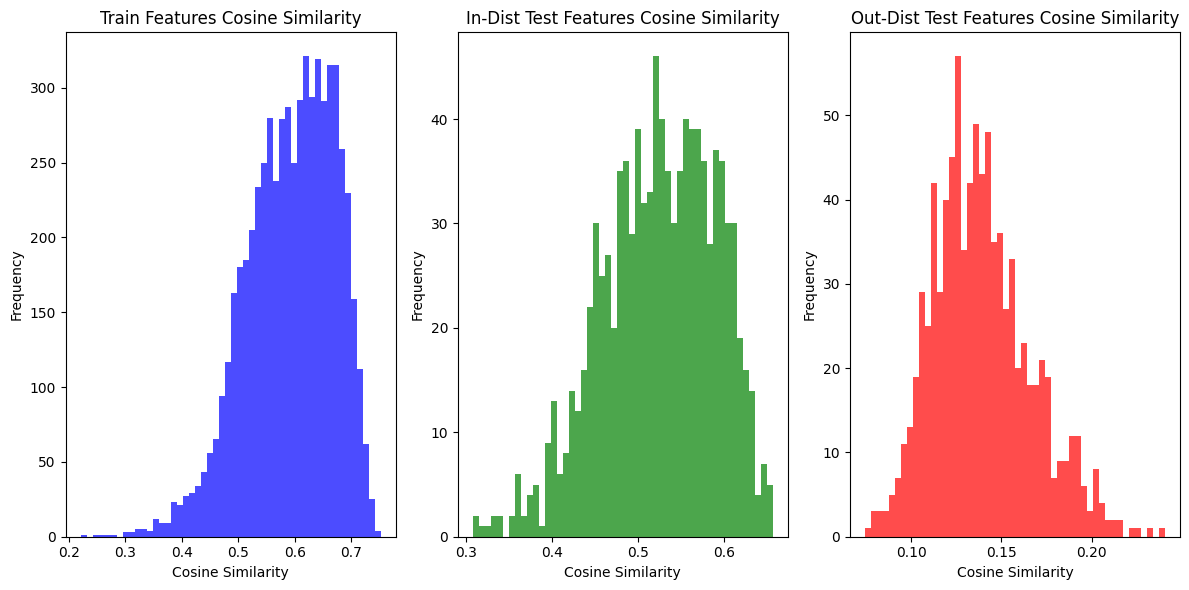

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create histograms
plt.figure(figsize=(12, 6))

# Train Features Histogram
plt.subplot(1, 3, 1)
plt.hist(cosine_train_similarities, bins=50, color='blue', alpha=0.7)
plt.title('Train Features Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# In-Dist Test Features Histogram
plt.subplot(1, 3, 2)
plt.hist(cosine_in_dist_similarities, bins=50, color='green', alpha=0.7)
plt.title('In-Dist Test Features Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# Out-Dist Test Features Histogram
plt.subplot(1, 3, 3)
plt.hist(cosine_out_dist_similarities, bins=50, color='red', alpha=0.7)
plt.title('Out-Dist Test Features Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
